# Team - NovaX # Model-X compettion



## Data Loading and Filtering

To handle the large data set, here will not load the entire file into memory. Instead,try to use pandas to read only the specific non-medical columns that we want and will also simultaneously instruct pandas to recognize the special codes (-4, 8, 9)from the Data Dictionary as missing values(NaN) in nessasary columns
"

In [437]:
# main importings 
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, f1_score, recall_score, accuracy_score, roc_auc_score,confusion_matrix,
    make_scorer,RocCurveDisplay)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [325]:
columns_needed = [
    # Target
    'DEMENTED',
    
    # A1: Demographics
    'NACCAGE', 'SEX', 'NACCNIHR', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED',

    # b1: Physical & A5: Lifestyle do the person usually do have these
    'HEIGHT', 'WEIGHT','VISION', 'VISCORR', 'HEARING', 'HEARAID','TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER',
    'ALCOCCAS', 'ALCFREQ', 'ALCOHOL','ABUSOTHR','APNEA', 'RBD', 'INSOMN', 'OTHSLEEP',
    
    # A5: Health History do the person has this in past
    'CVHATT',      # Heart attack
    'CVAFIB',      # Atrial fibrillation
    'CBSTROKE',    # Stroke
    'CBTIA',       # Mini-stroke
    'PD',          # Parkinson's
    'SEIZURES',
    'NACCTBI',     # Traumatic Brain Injury
    'DIABETES',
    'HYPERTEN',
    'HYPERCHO',    # High cholesterol
    'B12DEF','THYROID','ARTHRIT',
    
    #A5: Psychiatric History - person suffer from these
    'PTSD', 'BIPOLAR', 'SCHIZ', 'DEP2YRS', 'DEPOTHR', 'ANXIETY', 'OCD', 'NPSYDEV',

    # A3: Family History -  what family members had
    'NACCFAM', 'NACCMOM', 'NACCDAD',
    
    #  A4: Medication
    'ANYMEDS', 'NACCAMD' # Total number of meds
]

## Data cleaning and Preprocessing
#### filter the data and add NAN values to clean


In [326]:
file_path = 'Dementia Prediction Dataset.csv'

try:
    df = pd.read_csv(file_path, usecols=columns_needed)
    print("Data Loaded Successfully!")

    general_codes = [-4, 8, 9, 99]
    columns_to_clean_general = [
        'SEX', 'NACCNIHR', 'PRIMLANG', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED',
        'VISION', 'VISCORR', 'HEARING', 'HEARAID', 'TOBAC30', 'TOBAC100', 'ALCOCCAS', 'ALCFREQ', 
        'ALCOHOL', 'ABUSOTHR', 'APNEA', 'RBD', 'INSOMN', 'OTHSLEEP',
        'CVHATT', 'CVAFIB', 'CBSTROKE', 'CBTIA', 'PD', 'SEIZURES', 'NACCTBI', 
        'DIABETES', 'HYPERTEN', 'HYPERCHO', 'B12DEF', 'THYROID', 'ARTHRIT',
        'PTSD', 'BIPOLAR', 'SCHIZ', 'DEP2YRS', 'DEPOTHR', 'ANXIETY', 'OCD', 'NPSYDEV',
        'NACCFAM', 'NACCMOM', 'NACCDAD', 'ANYMEDS'
    ]
    for col in columns_to_clean_general:
        if col in df.columns:
            df[col] = df[col].replace(general_codes, np.nan)

    # must treat these carefully to avoid deleting good data.    
    # 'EDUC': 9 is valid, but -4 and 99 are missing. so we will ensure about it more
    if 'EDUC' in df.columns:
        df['EDUC'] = df['EDUC'].replace([-4, 99], np.nan)
        
    # 'SMOKYRS': 9 is valid, but -4, 88, and 99 are missing.
    if 'SMOKYRS' in df.columns:
        df['SMOKYRS'] = df['SMOKYRS'].replace([-4, 88, 99], np.nan)
        
    # 'PACKSPER': 4 is valid, but -4, 8, and 9 are missing.
    if 'PACKSPER' in df.columns:
        df['PACKSPER'] = df['PACKSPER'].replace([-4, 8, 9], np.nan)
        
    # 'HEIGHT', 'WEIGHT', 'NACCAMD': 8, 9, 99 are "Unknown"
    # These are numerical, but 8 or 9 are not valid measures.
    if 'HEIGHT' in df.columns:
        df['HEIGHT'] = df['HEIGHT'].replace([-4, 8, 9, 99], np.nan)
    if 'WEIGHT' in df.columns:
        df['WEIGHT'] = df['WEIGHT'].replace([-4, 8, 9, 99], np.nan)
    if 'NACCAMD' in df.columns:
        df['NACCAMD'] = df['NACCAMD'].replace([-4, 8, 9, 99], np.nan)

    # 'NACCAGE' is assumed to be clean (no special codes there)

    #get teh summery
    df.info()
 
except FileNotFoundError:
    print(f"File not found.")
except ValueError as e:
    print(f" A problem occurred with the columns. {e}")


Data Loaded Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195196 entries, 0 to 195195
Data columns (total 55 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEX       195196 non-null  int64  
 1   PRIMLANG  192164 non-null  float64
 2   EDUC      194222 non-null  float64
 3   MARISTAT  194300 non-null  float64
 4   NACCLIVS  194872 non-null  float64
 5   INDEPEND  194599 non-null  float64
 6   RESIDENC  192318 non-null  float64
 7   HANDED    194164 non-null  float64
 8   NACCFAM   177430 non-null  float64
 9   NACCMOM   189004 non-null  float64
 10  NACCDAD   186937 non-null  float64
 11  ANYMEDS   192457 non-null  float64
 12  TOBAC30   123036 non-null  float64
 13  TOBAC100  122272 non-null  float64
 14  SMOKYRS   119634 non-null  float64
 15  PACKSPER  119730 non-null  float64
 16  ALCOCCAS  19326 non-null   float64
 17  ALCFREQ   12241 non-null   float64
 18  CVHATT    123136 non-null  float64
 19  CVAFIB    122935 n

### anlysing the `df.info`


Our df.info() output from above  we can see 195,196 total rows. While primary columns like NACCAGE and DEMENTED are 100% complete, we face a critical strategic challenge.

The Problem is that 90% Missing Data are here , A large group of our most promising features are like 90% empty.
Ex:-
ALCOCCAS (only 19k non-null),ARTHRIT (19k non-null),All Sleep Disorder features (APNEA, RBD, INSOMN, etc.)
,All Psychiatric History features (ANXIETY, PTSD, BIPOLAR, etc.)

Reason:- As we know The Data Dictionary confirms these questions were only added in the UDS v3.0 form. All subjects from older v1.0 and v2.0 forms do not have this data.

So we have to do get a 

- Data:- Use all 190000+ rows and then

- Features:- We will drop the 90%-empty columns (ANXIETY, ARTHRIT, etc.). We will build a model using only the "common" features with high data availability (ex:- NACCAGE, EDUC, DIABETES, STROKE).

- Goal:- A stable, generalized model trained on the full dataset.


In [327]:
df.head(5)

,SEX,PRIMLANG,EDUC,MARISTAT,NACCLIVS,INDEPEND,RESIDENC,HANDED,NACCFAM,NACCMOM,...,HEIGHT,WEIGHT,VISION,VISCORR,HEARING,HEARAID,DEMENTED,NACCNIHR,NACCAGE,NACCAMD
0,1,1.0,16.0,1.0,4.0,1.0,1.0,2.0,1.0,0.0,...,71.0,232.0,0.0,1.0,1.0,0.0,0,1.0,70,13.0
1,1,1.0,16.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,...,71.0,220.0,0.0,1.0,1.0,0.0,0,1.0,71,12.0
2,1,1.0,16.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,...,72.0,175.0,NaN,NaN,1.0,0.0,0,1.0,66,4.0
3,2,2.0,16.0,1.0,2.0,2.0,1.0,2.0,NaN,NaN,...,88.8,888.0,1.0,0.0,1.0,0.0,1,1.0,63,3.0
4,1,1.0,12.0,3.0,1.0,1.0,1.0,2.0,NaN,0.0,...,65.0,114.0,0.0,1.0,0.0,0.0,0,1.0,77,1.0


In [328]:
# drop all the columns with 90% missing dsata
#We set our threshold to 30,000 based on the cliff we saw in the df.info()

min_data_threshold = 30000

# findingg the columns do not meet the threshold
columns_to_drop = df.columns[df.count() < min_data_threshold]

columns_to_drop = [col for col in columns_to_drop if col != 'DEMENTED']

In [329]:
columns_to_drop

['ALCOCCAS',
 'ALCFREQ',
 'ARTHRIT',
 'APNEA',
 'RBD',
 'INSOMN',
 'OTHSLEEP',
 'PTSD',
 'BIPOLAR',
 'SCHIZ',
 'ANXIETY',
 'OCD',
 'NPSYDEV']

In [330]:
df_base_model = df.drop(columns=columns_to_drop)
df_base_model

,SEX,PRIMLANG,EDUC,MARISTAT,NACCLIVS,INDEPEND,RESIDENC,HANDED,NACCFAM,NACCMOM,...,HEIGHT,WEIGHT,VISION,VISCORR,HEARING,HEARAID,DEMENTED,NACCNIHR,NACCAGE,NACCAMD
0,1,1.0,16.0,1.0,4.0,1.0,1.0,2.0,1.0,0.0,...,71.0,232.0,0.0,1.0,1.0,0.0,0,1.0,70,13.0
1,1,1.0,16.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,...,71.0,220.0,0.0,1.0,1.0,0.0,0,1.0,71,12.0
2,1,1.0,16.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,...,72.0,175.0,NaN,NaN,1.0,0.0,0,1.0,66,4.0
3,2,2.0,16.0,1.0,2.0,2.0,1.0,2.0,NaN,NaN,...,88.8,888.0,1.0,0.0,1.0,0.0,1,1.0,63,3.0
4,1,1.0,12.0,3.0,1.0,1.0,1.0,2.0,NaN,0.0,...,65.0,114.0,0.0,1.0,0.0,0.0,0,1.0,77,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195191,2,1.0,13.0,4.0,4.0,2.0,NaN,2.0,NaN,0.0,...,88.8,888.0,0.0,1.0,0.0,1.0,1,2.0,72,10.0
195192,1,1.0,13.0,2.0,1.0,1.0,1.0,2.0,NaN,0.0,...,71.7,196.0,0.0,1.0,0.0,1.0,0,1.0,87,7.0
195193,1,1.0,13.0,2.0,1.0,3.0,2.0,2.0,NaN,0.0,...,72.0,200.0,0.0,1.0,0.0,0.0,1,1.0,89,5.0
195194,1,1.0,13.0,2.0,1.0,3.0,2.0,2.0,NaN,0.0,...,73.0,193.0,0.0,1.0,0.0,1.0,1,1.0,89,10.0


In [331]:
df_base_model.shape

(195196, 42)

##### try to remeove any duplicaets in this

In [332]:
num_duplicates = df_base_model.duplicated().sum()
num_duplicates

np.int64(933)

In [333]:
# there are duplicates
df_base_model=df_base_model.drop_duplicates()
df_base_model.shape

(194263, 42)

##### Impute Missing Tobacco Data

As we discussed, we cannot blindly fill all NaNs in SMOKYRS (Years Smoked) with 0. There are two types of NaNs:

Logical NaNs: TOBAC100 = 0 (No), so SMOKYRS is skipped. These should be 0.

True Missing NaNs: TOBAC100 = 1 (Yes), but the person forgot to answer SMOKYRS. These should not be 0.

we will only fill the "Logical NaNs" (Case 1). The "True Missing NaNs" (Case 2) will be handled later in our general imputation step (use with the median or most appropriate value).

In [334]:
# We assume if it's missing, they are likely a non-smoker (0).
if 'TOBAC100' in df_base_model.columns:
    df_base_model['TOBAC100'] = df_base_model['TOBAC100'].fillna(0)

C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\283930109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_model['TOBAC100'] = df_base_model['TOBAC100'].fillna(0)


In [335]:
# Now, apply the conditional logic
# Condition:- Where TOBAC100 is 0 as NO
condition_non_smoker = (df_base_model['TOBAC100'] == 0)
tobacco_cols_to_fill = ['SMOKYRS', 'PACKSPER', 'TOBAC30']

for col in tobacco_cols_to_fill:
    if col in df_base_model.columns:
        # We fill NaNs with 0 ONLY for the rows that meet the condition
        df_base_model.loc[condition_non_smoker, col] = df_base_model.loc[condition_non_smoker, col].fillna(0)


In [336]:
df_base_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194263 entries, 0 to 195195
Data columns (total 42 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEX       194263 non-null  int64  
 1   PRIMLANG  191237 non-null  float64
 2   EDUC      193290 non-null  float64
 3   MARISTAT  193367 non-null  float64
 4   NACCLIVS  193939 non-null  float64
 5   INDEPEND  193666 non-null  float64
 6   RESIDENC  191393 non-null  float64
 7   HANDED    193232 non-null  float64
 8   NACCFAM   176572 non-null  float64
 9   NACCMOM   188144 non-null  float64
 10  NACCDAD   186078 non-null  float64
 11  ANYMEDS   191595 non-null  float64
 12  TOBAC30   194193 non-null  float64
 13  TOBAC100  194263 non-null  float64
 14  SMOKYRS   191491 non-null  float64
 15  PACKSPER  191611 non-null  float64
 16  CVHATT    123090 non-null  float64
 17  CVAFIB    122888 non-null  float64
 18  CBSTROKE  123018 non-null  float64
 19  CBTIA     122327 non-null  float64
 20  PD       

In [337]:
df_base_model.isnull().sum()

SEX             0
PRIMLANG     3026
EDUC          973
MARISTAT      896
NACCLIVS      324
INDEPEND      597
RESIDENC     2870
HANDED       1031
NACCFAM     17691
NACCMOM      6119
NACCDAD      8185
ANYMEDS      2668
TOBAC30        70
TOBAC100        0
SMOKYRS      2772
PACKSPER     2652
CVHATT      71173
CVAFIB      71375
CBSTROKE    71245
CBTIA       71936
PD          71166
SEIZURES    71316
NACCTBI     72018
DIABETES    71201
HYPERTEN    71203
HYPERCHO    71913
B12DEF      73070
THYROID     71683
ALCOHOL     71190
ABUSOTHR    71135
DEP2YRS     71915
DEPOTHR     72505
HEIGHT      25506
WEIGHT      25691
VISION      27974
VISCORR     27260
HEARING     27835
HEARAID     27171
DEMENTED        0
NACCNIHR     2557
NACCAGE         0
NACCAMD     31625
dtype: int64

## Feature engineering with data cleaning
use technique to shortage the columns furthermrore
use BMI instead of height,weight

We will:
- Calculate BMI using the formula: BMI = Weight (kg) / Height (m)^2
- Convert our units (inches to meters, lbs to kg).
- Create the new BMI column.Drop the original HEIGHT and WEIGHT columns to simplify our dataset

In [339]:
height = df_base_model['HEIGHT']* 0.0254  # 1 inch = 0.0254 m
weight = df_base_model['WEIGHT']* 0.453592 # 1 lb = 0.453592 kg

df_base_model['BMI'] = weight/(height**2)
df_base_model['BMI'] = df_base_model['BMI'].replace([np.inf,-np.inf],np.nan)

C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\2500415541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_model['BMI'] = weight/(height**2)
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\2500415541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_model['BMI'] = df_base_model['BMI'].replace([np.inf,-np.inf],np.nan)


In [340]:
df_base_model['BMI']

0         32.357074
1         30.683432
2         23.734004
3         79.174438
4         18.970383
            ...    
195191    79.174438
195192    26.804994
195193    27.124576
195194    25.462998
195195    26.660474
Name: BMI, Length: 194263, dtype: float64

In [341]:
df_base_model = df_base_model.drop(columns=['HEIGHT','WEIGHT'])

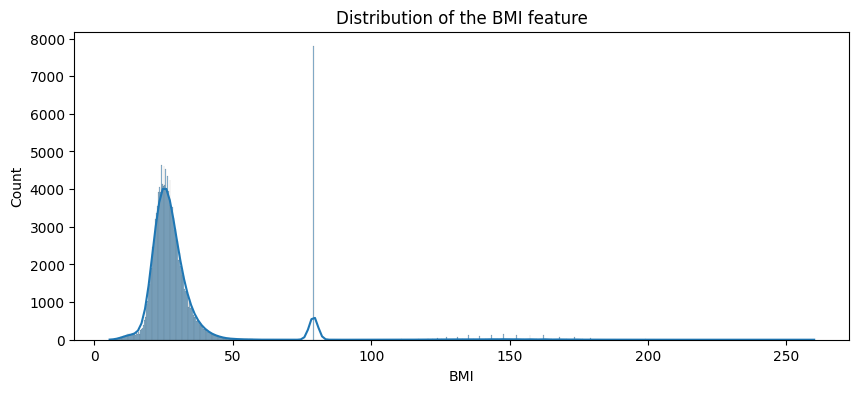

In [342]:
# look at the distribution of the BMI feature
plt.figure(figsize=(10,4))
sns.histplot(df_base_model['BMI'].dropna(),kde=True)
plt.title('Distribution of the BMI feature')
plt.show()

We will:

- Plot a boxplot of the original (dirty) BMI data to visually confirm the data entry errors.

- Define a plausible BMI range (15 to 55) and set all values outside it to NaN.

- Plot a second boxplot of the cleaned BMI data to confirm the outliers were successfully removed.

<Axes: xlabel='BMI'>

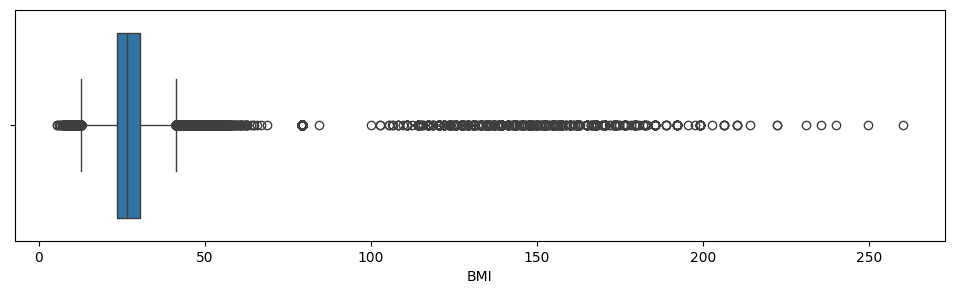

In [343]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=df_base_model['BMI'])
# before cleaning

In [344]:
# define our plasusible BMI range to 15 - 55 and will clean others
min_bmi = 15
max_bmi = 55


df_base_model.loc[(df_base_model['BMI']<min_bmi) | (df_base_model['BMI']>max_bmi), 'BMI'] = np.nan

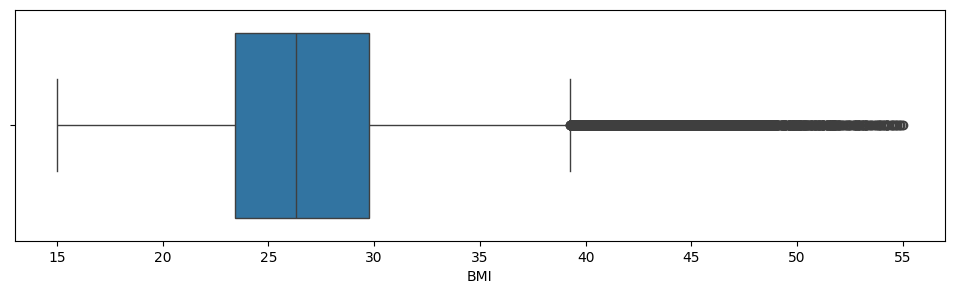

In [345]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=df_base_model['BMI'].dropna())
plt.show()

boxplots for each of our main numerical features to quickly check their quality

In [346]:
numerical_features_to_check = ['NACCAGE', 'EDUC', 'SMOKYRS', 'NACCAMD']

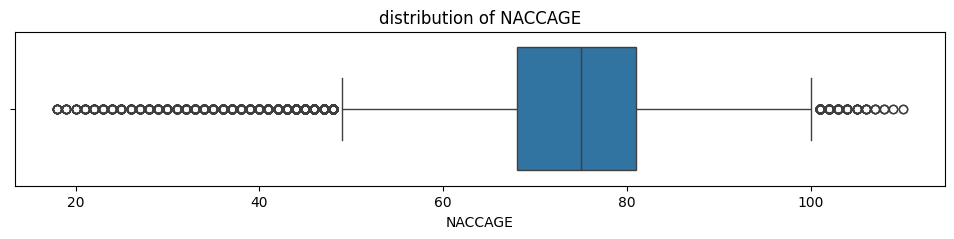

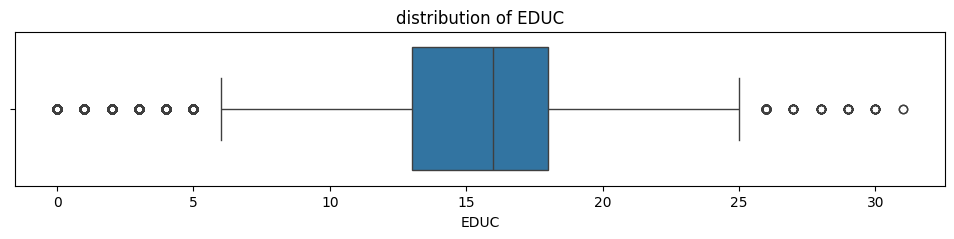

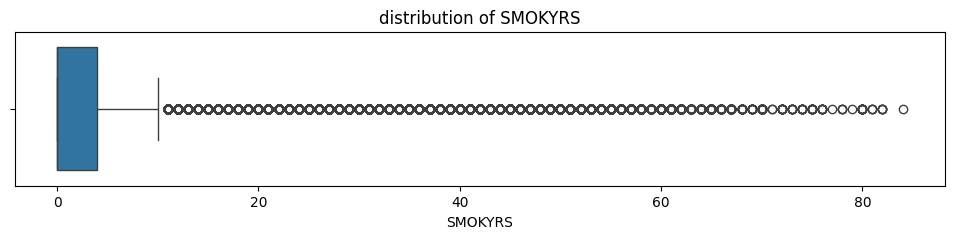

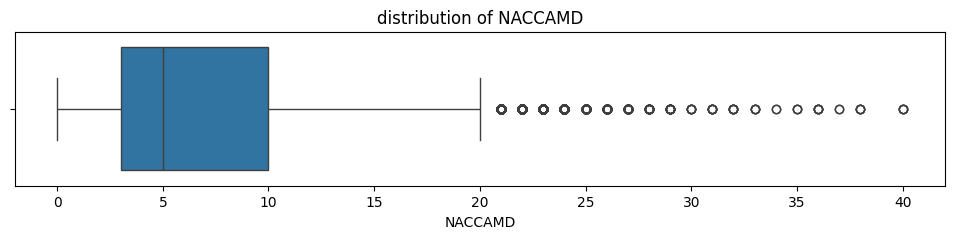

In [347]:
for col in numerical_features_to_check:
    if col in df_base_model.columns:
        plt.figure(figsize=(12,2))
        sns.boxplot(x=df_base_model[col].dropna())
        plt.title(f'distribution of {col}')
        plt.xlabel(col)
        plt.show()

lets find is they any not valid in numerical

In [348]:
# allowablew range 18-120 in there
count_outliers1 = df_base_model['NACCAGE'][df_base_model['NACCAGE']>120].count()
# df_base_model.loc[df_base_model['NACCAGE']>100, 'NACCAGE'] = np.nan 
count_outliers1

np.int64(0)

In [349]:
count_outliers2 = df_base_model['EDUC'][df_base_model['EDUC']>36].count()
count_outliers2


np.int64(0)

In [350]:

df_base_model['PACKSPER'] = df_base_model['PACKSPER'].replace([-4, 8, 9], np.nan)
    
#logical errors (any value > 5)
count_outliers = df_base_model['PACKSPER'][df_base_model['PACKSPER'] > 5].count()
count_outliers

np.int64(0)

now we look at the target varible - DEMENTED to find impbalancing

In [351]:
df_base_model['DEMENTED']

0         0
1         0
2         0
3         1
4         0
         ..
195191    1
195192    0
195193    1
195194    1
195195    0
Name: DEMENTED, Length: 194263, dtype: int64

In [352]:
target_counts = df_base_model['DEMENTED'].value_counts()
target_counts

DEMENTED
0    136821
1     57442
Name: count, dtype: int64

In [353]:
df_base_model['DEMENTED'].value_counts(normalize=True) * 100

DEMENTED
0    70.430808
1    29.569192
Name: proportion, dtype: float64

can be seen some unbalanced here

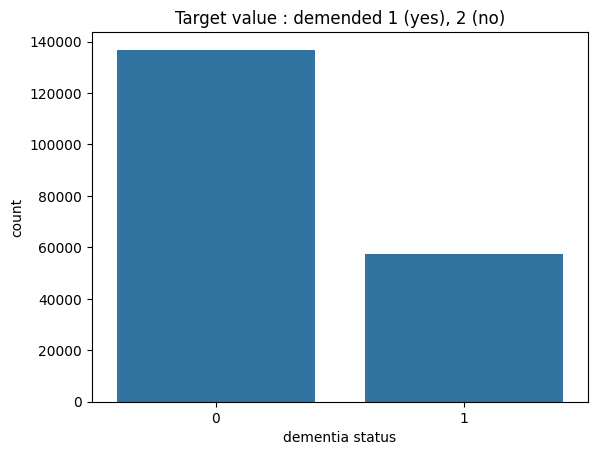

In [354]:
sns.countplot(x='DEMENTED', data = df_base_model)
plt.title('Target value : demended 1 (yes), 2 (no)')
plt.ylabel('count')
plt.xlabel('dementia status')
plt.xticks([0,1])
plt.show()

The 70/30 split is "moderately imbalanced". If we train on it, the model will be biased.so we will do Oversampling teqnique like SMOTE or ADASYN is to perfect solution to get to 50/50.But, before it follow one very important thing to prevent data leakage, clean all NaN values and then we will split our data into a train set and a test set.after will apply above technique only to the train set.


#### next fill numerical NaNs(like BMI, EDUC) with their column's Median value  or use KNN method. Fill categorical NaNs (like MARISTAT, DIABETES) with their column's Mode

In [355]:
df_simple_imputed = df_base_model.copy()

In [356]:
# true_numerical = ['NACCAGE','EDUC','SMOKYRS']

In [357]:

df_knn_imputed = df_base_model.copy()

# identify feature types
true_numerical = ['NACCAGE', 'EDUC', 'SMOKYRS', 'PACKSPER', 'NACCAMD', 'BMI']
all_features = df_base_model.columns.drop('DEMENTED')
true_categorical = [col for col in all_features if col not in true_numerical]

# k=5 is the hyperparameter (number of neighbors)
knn_imputer = KNNImputer(n_neighbors=5) 
cat_imputer = SimpleImputer(strategy='most_frequent')

#Apply the Imputers (Mixed Strategy)
df_knn_imputed[true_categorical] = cat_imputer.fit_transform(df_knn_imputed[true_categorical])
df_knn_imputed[true_numerical] = knn_imputer.fit_transform(df_knn_imputed[true_numerical])

print("Successfully created 'df_knn_imputed'!")

df_knn_imputed.info()


Successfully created 'df_knn_imputed'!
<class 'pandas.core.frame.DataFrame'>
Index: 194263 entries, 0 to 195195
Data columns (total 41 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEX       194263 non-null  float64
 1   PRIMLANG  194263 non-null  float64
 2   EDUC      194263 non-null  float64
 3   MARISTAT  194263 non-null  float64
 4   NACCLIVS  194263 non-null  float64
 5   INDEPEND  194263 non-null  float64
 6   RESIDENC  194263 non-null  float64
 7   HANDED    194263 non-null  float64
 8   NACCFAM   194263 non-null  float64
 9   NACCMOM   194263 non-null  float64
 10  NACCDAD   194263 non-null  float64
 11  ANYMEDS   194263 non-null  float64
 12  TOBAC30   194263 non-null  float64
 13  TOBAC100  194263 non-null  float64
 14  SMOKYRS   194263 non-null  float64
 15  PACKSPER  194263 non-null  float64
 16  CVHATT    194263 non-null  float64
 17  CVAFIB    194263 non-null  float64
 18  CBSTROKE  194263 non-null  float64
 19  CBTIA     

##### save the file for after use beacuse there is lot of time consuming

In [ ]:
# output_filename = 'df_clean_knn_imputed.csv' # saved the file KNN imputed
# df_knn_imputed.to_csv(output_filename, index=False)

In [35]:
# df_knn_imputed = pd.readcsv("df_clean_knn_imputed")

#### Visualizing Numerical Feature Distributions vs DEMENTED

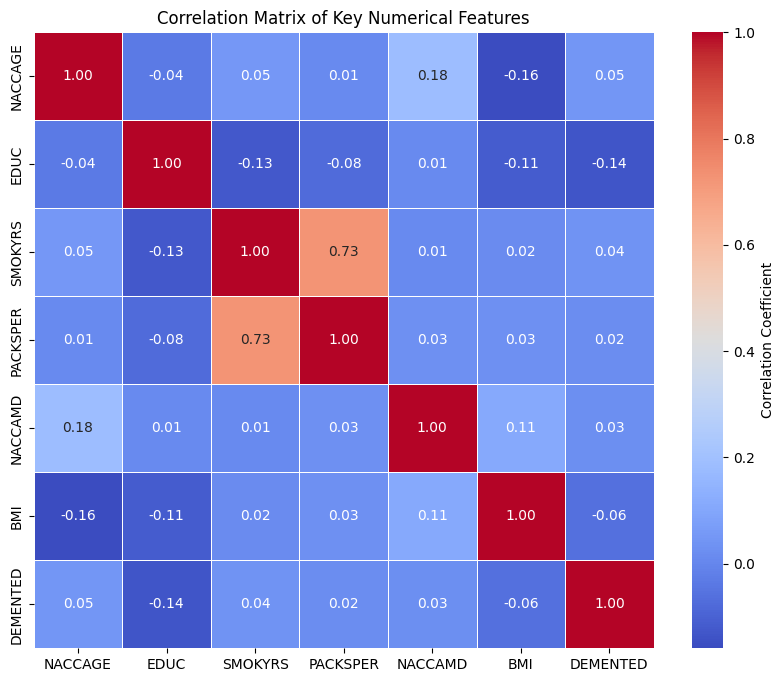

In [358]:
# We use the DataFrame without NaN values
df_copy = df_knn_imputed.copy()

# Select ONLY the numerical features
numerical_features_to_check = [
    'NACCAGE', 'EDUC', 'SMOKYRS', 'PACKSPER', 'NACCAMD', 'BMI', 'DEMENTED' # Also include the target for context
]
df_corr = df_copy[numerical_features_to_check]

#Calculate the Correlation Matrix
correlation_matrix = df_corr.corr()


plt.figure(figsize=(10, 8))
# Use annot=True to show the numbers, fmt='.2f' to show 2 decimal places
sns.heatmap(correlation_matrix, 
    annot=True, cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5,cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix of Key Numerical Features')
plt.show()


as see except PACKSPER,SMOKYRS others are not highly corelated and because of anything is not above 0.8 no need to reduce or change any but we'll add a new feature with this 0.73 correlated features

### add a new feature  - Feature Engineering
SMOKYRS × PACKSPER ==> PACKYRS (packes per year)

In [359]:
# We use the KNN imputed dataframe (df_knn_imputed)
# Formula: Pack-Years = SMOKYRS × PACKSPER
df_knn_imputed['PACKYRS'] = df_knn_imputed['SMOKYRS'] * df_knn_imputed['PACKSPER']

df_knn_imputed[['SMOKYRS', 'PACKSPER', 'PACKYRS']].tail()

,SMOKYRS,PACKSPER,PACKYRS
195191,0.0,0.0,0.0
195192,40.0,2.0,80.0
195193,40.0,2.0,80.0
195194,40.0,2.0,80.0
195195,0.0,0.0,0.0


In [360]:
df_knn_imputed.shape

(194263, 42)

In [361]:
df_knn_imputed.drop(['SMOKYRS', 'PACKSPER'], axis=1, inplace=True)

In [362]:
df_knn_imputed.shape

(194263, 40)

### now we have only 40 features in here lets try to minimuze it more

Part A: Numerical Feature Distributions (KDE Plots)...


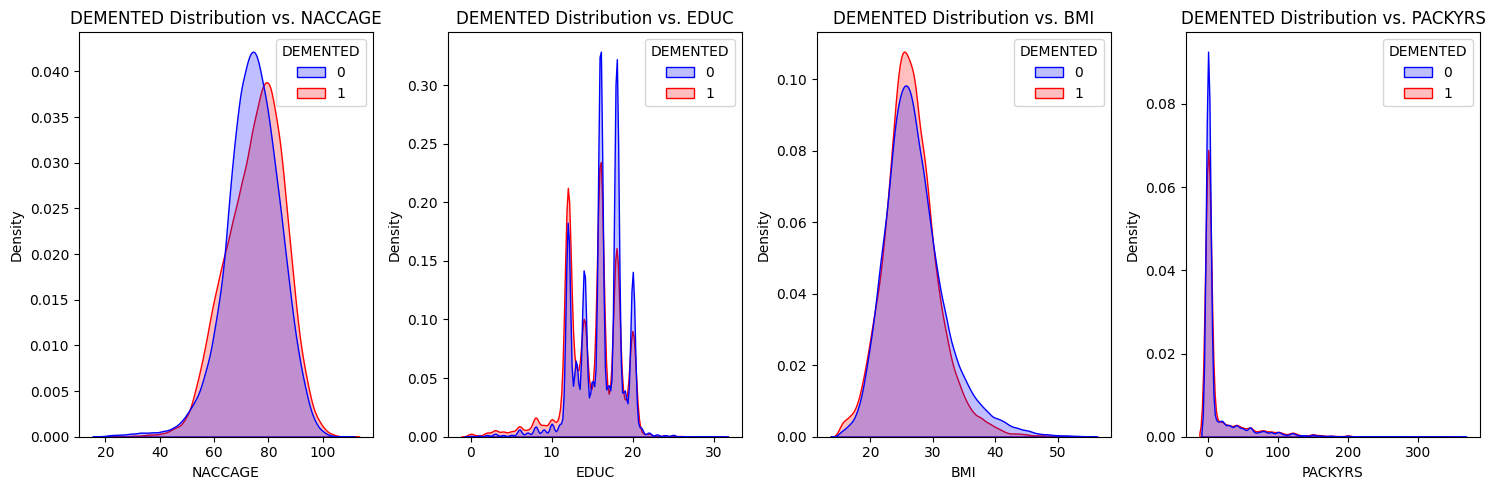

In [363]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df_knn_imputed.copy() 

# Ensure DEMENTED is treated as a category for plotting
df['DEMENTED'] = df['DEMENTED'].astype(int) 

#Numerical Features KDE Plots
print("Part A: Numerical Feature Distributions (KDE Plots)...")
numerical_features = ['NACCAGE', 'EDUC', 'BMI','PACKYRS']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features):
    plt.subplot(1, 4, i + 1)
    
    # Use a KDE Plot to compare the distribution of the feature across the two target classes
    sns.kdeplot(data=df, x=col, 
        hue='DEMENTED', fill=True, 
        palette={0: 'blue', 1: 'red'}, 
        common_norm=False
    )
    plt.title(f'DEMENTED Distribution vs. {col}', fontsize=12)

plt.tight_layout()
plt.show()


### WE can see that
- Red curve (with dementia) slightly shifted to the right, So people with dementia tend to be a little older than those without it.`Age` is a mild predictor.
- Curves almost overlap,People with and without dementia have almost the same education distribution.So education is not a strong predictor in our dataset.
- Slight difference dementia group has a tiny shift left slightly lower BMI , may not be very usedul predictor
- Both curves almost identical , A heavy spike at low pack-years for both groups weak feature
  
lets see after the model prediction do we need really remove these some features or not

#### Let us see how other  varibles differ with the demended

In [364]:
# Identify ALL categorical/count columns remaining
true_continuous_numerical_plus_engineered = ['NACCAGE', 'EDUC', 'NACCAMD', 'BMI', 'PACKYRS'] 
columns_to_plot = [col for col in df.columns if col not in true_continuous_numerical_plus_engineered and col != 'DEMENTED']

len(columns_to_plot)


34

C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\i

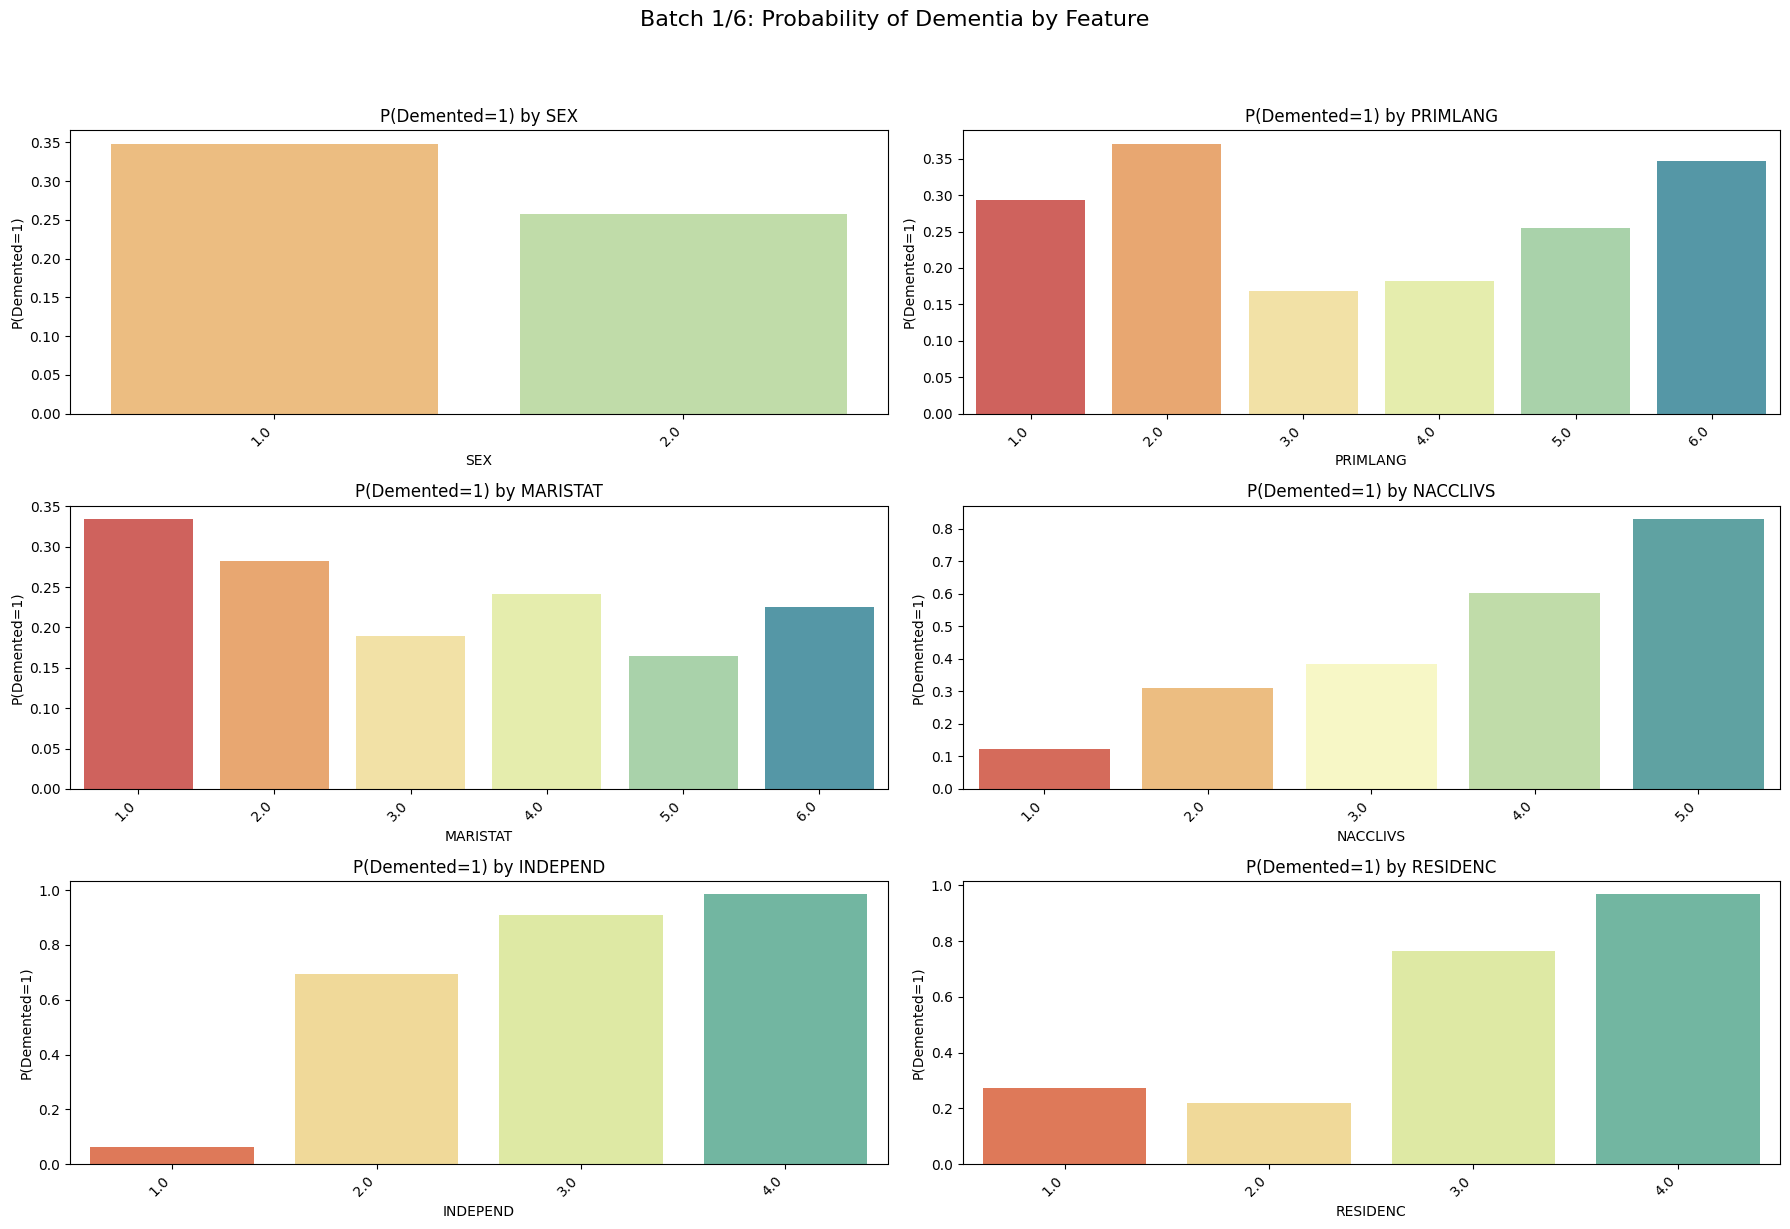

C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\i

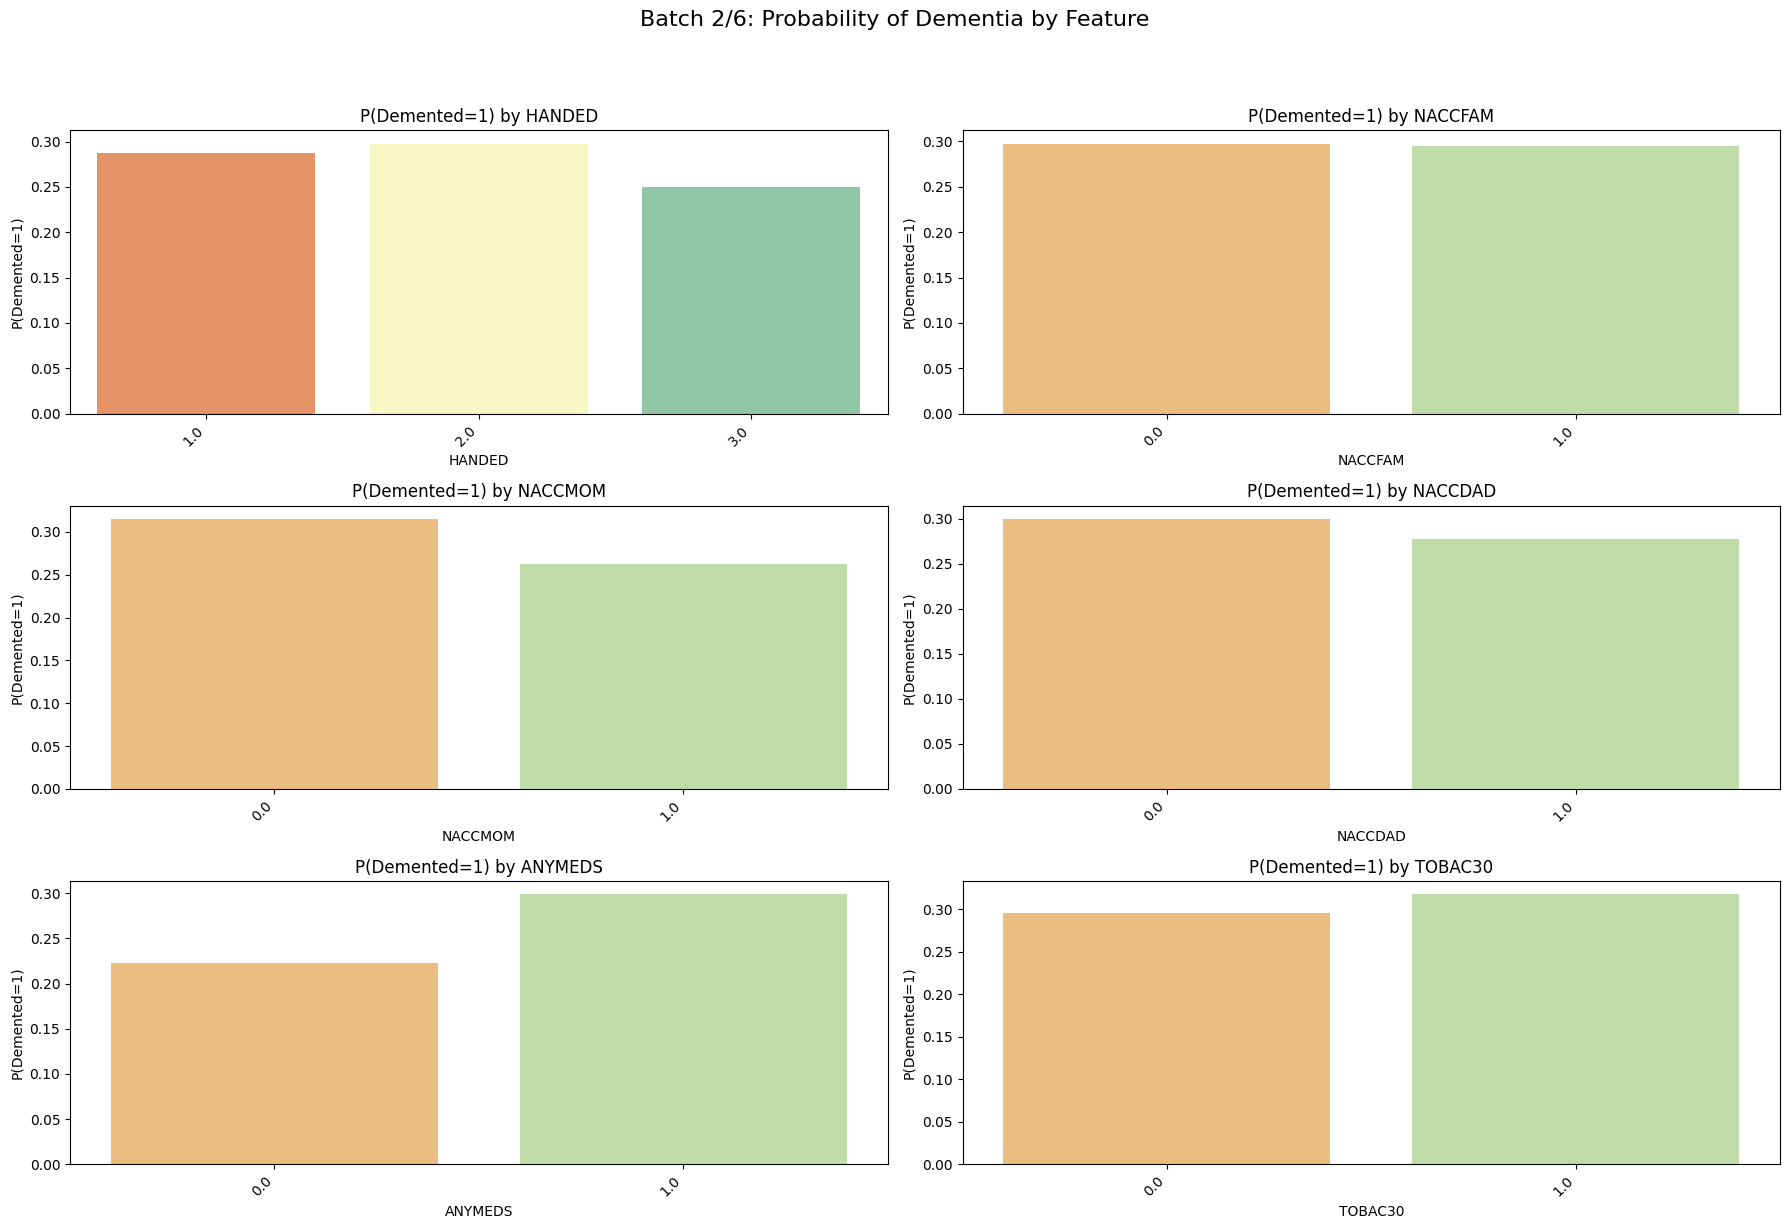

C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\i

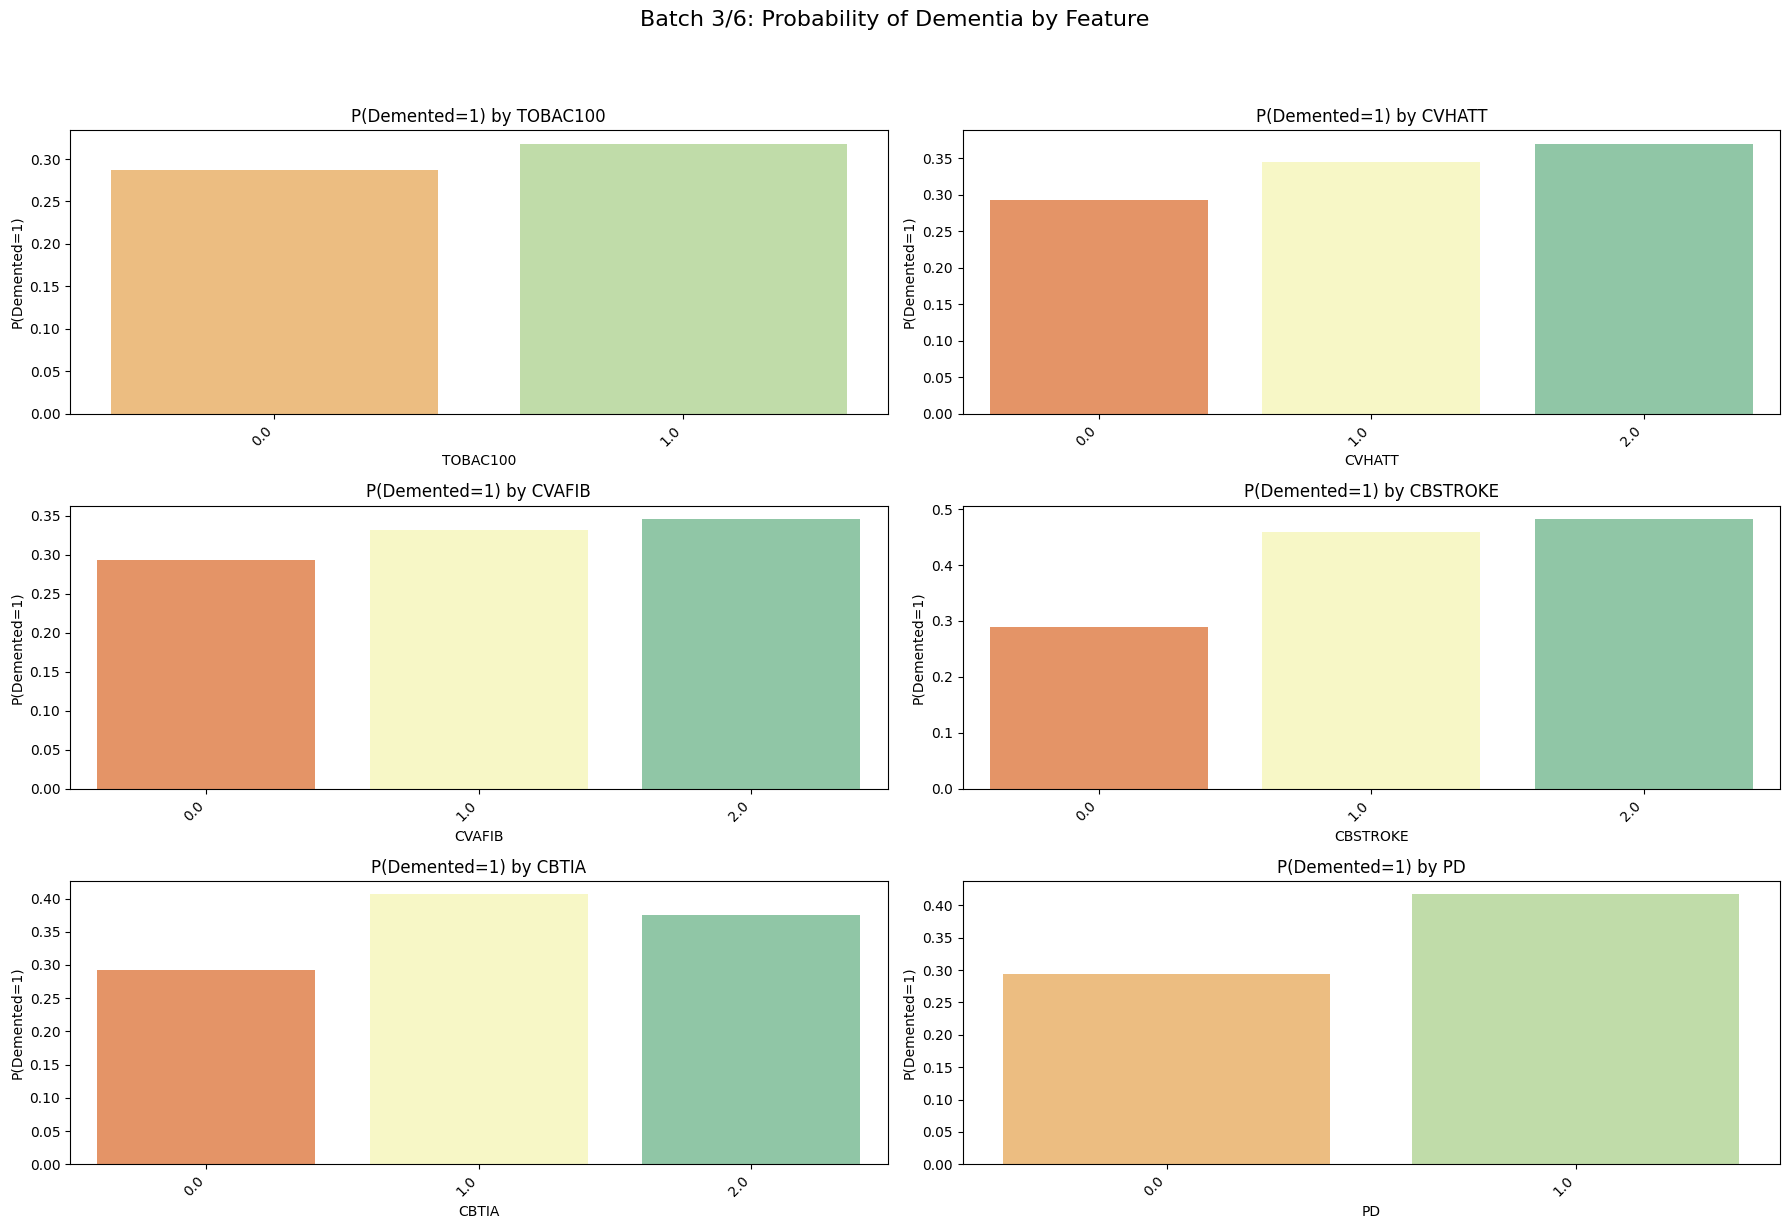

C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\i

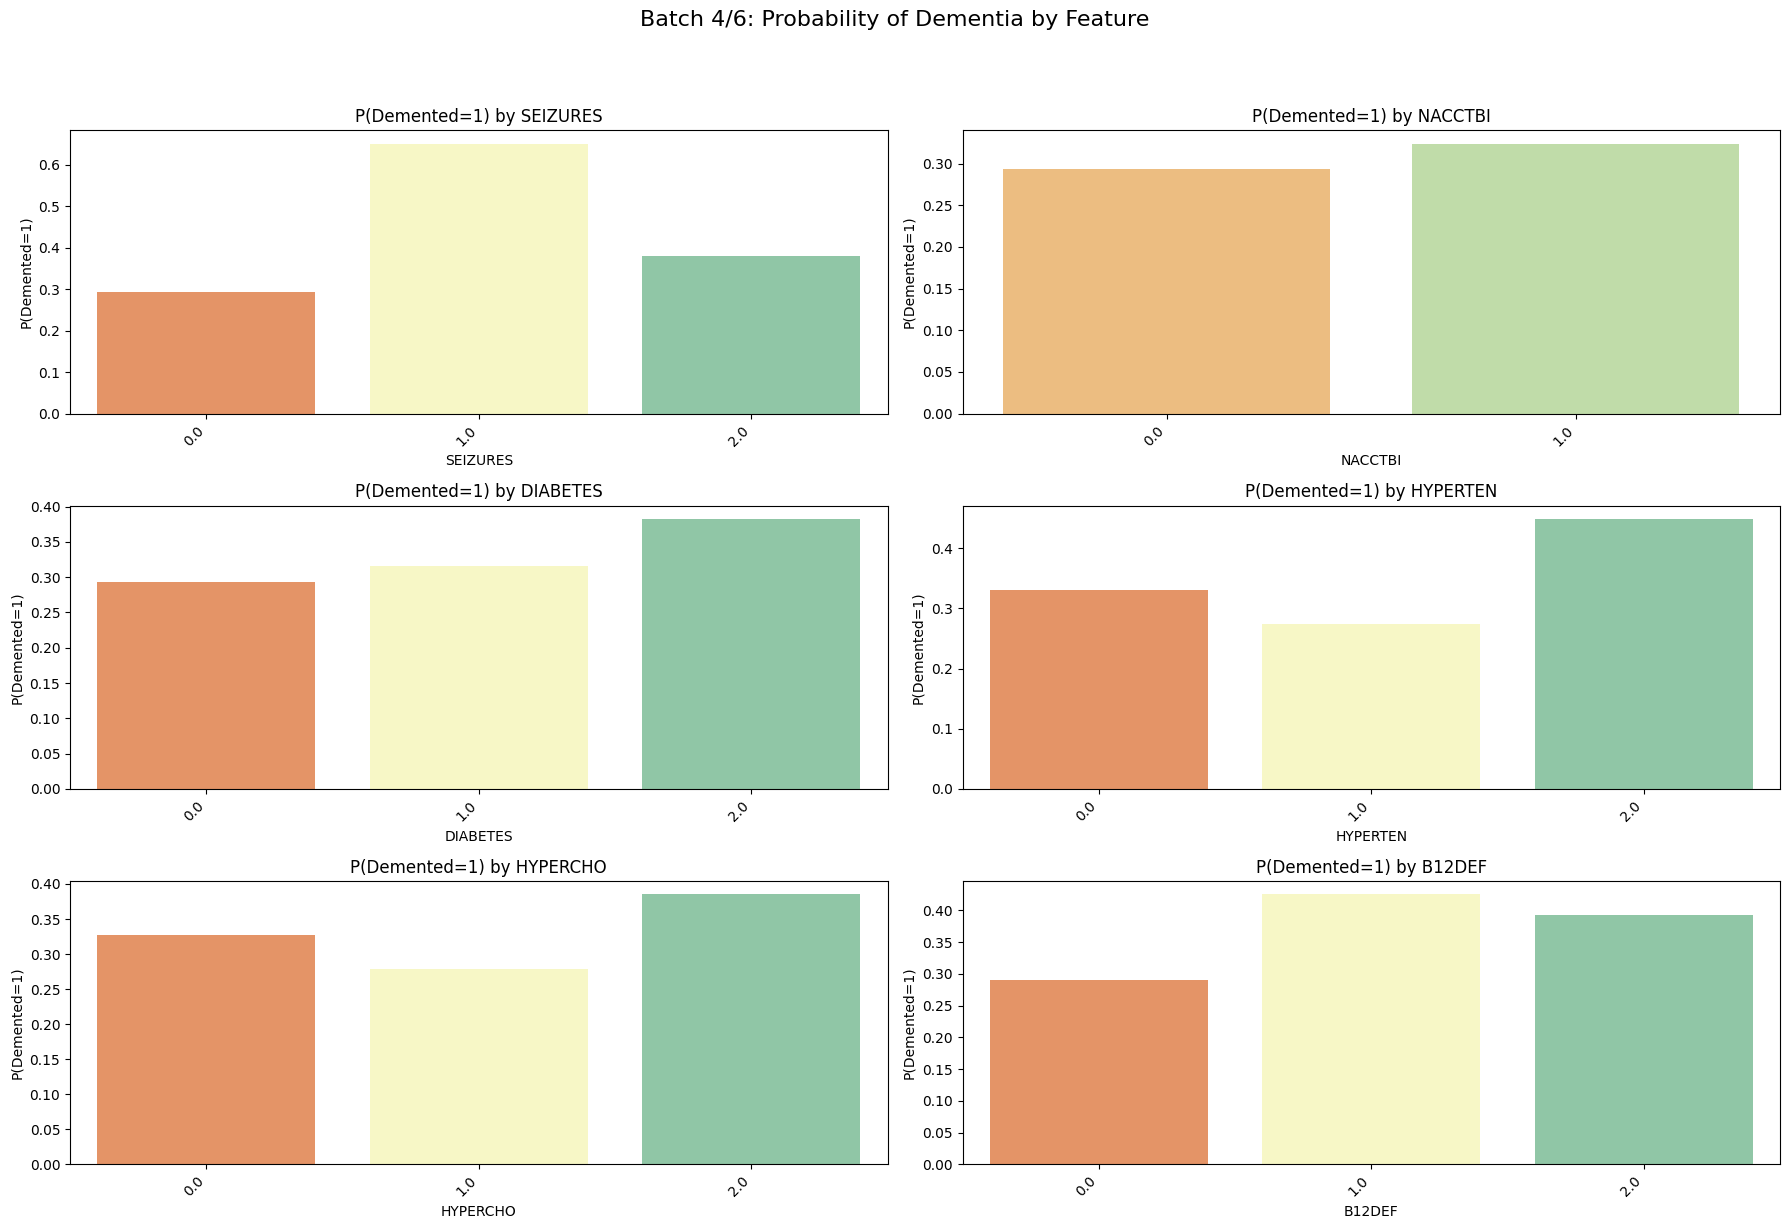

C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\i

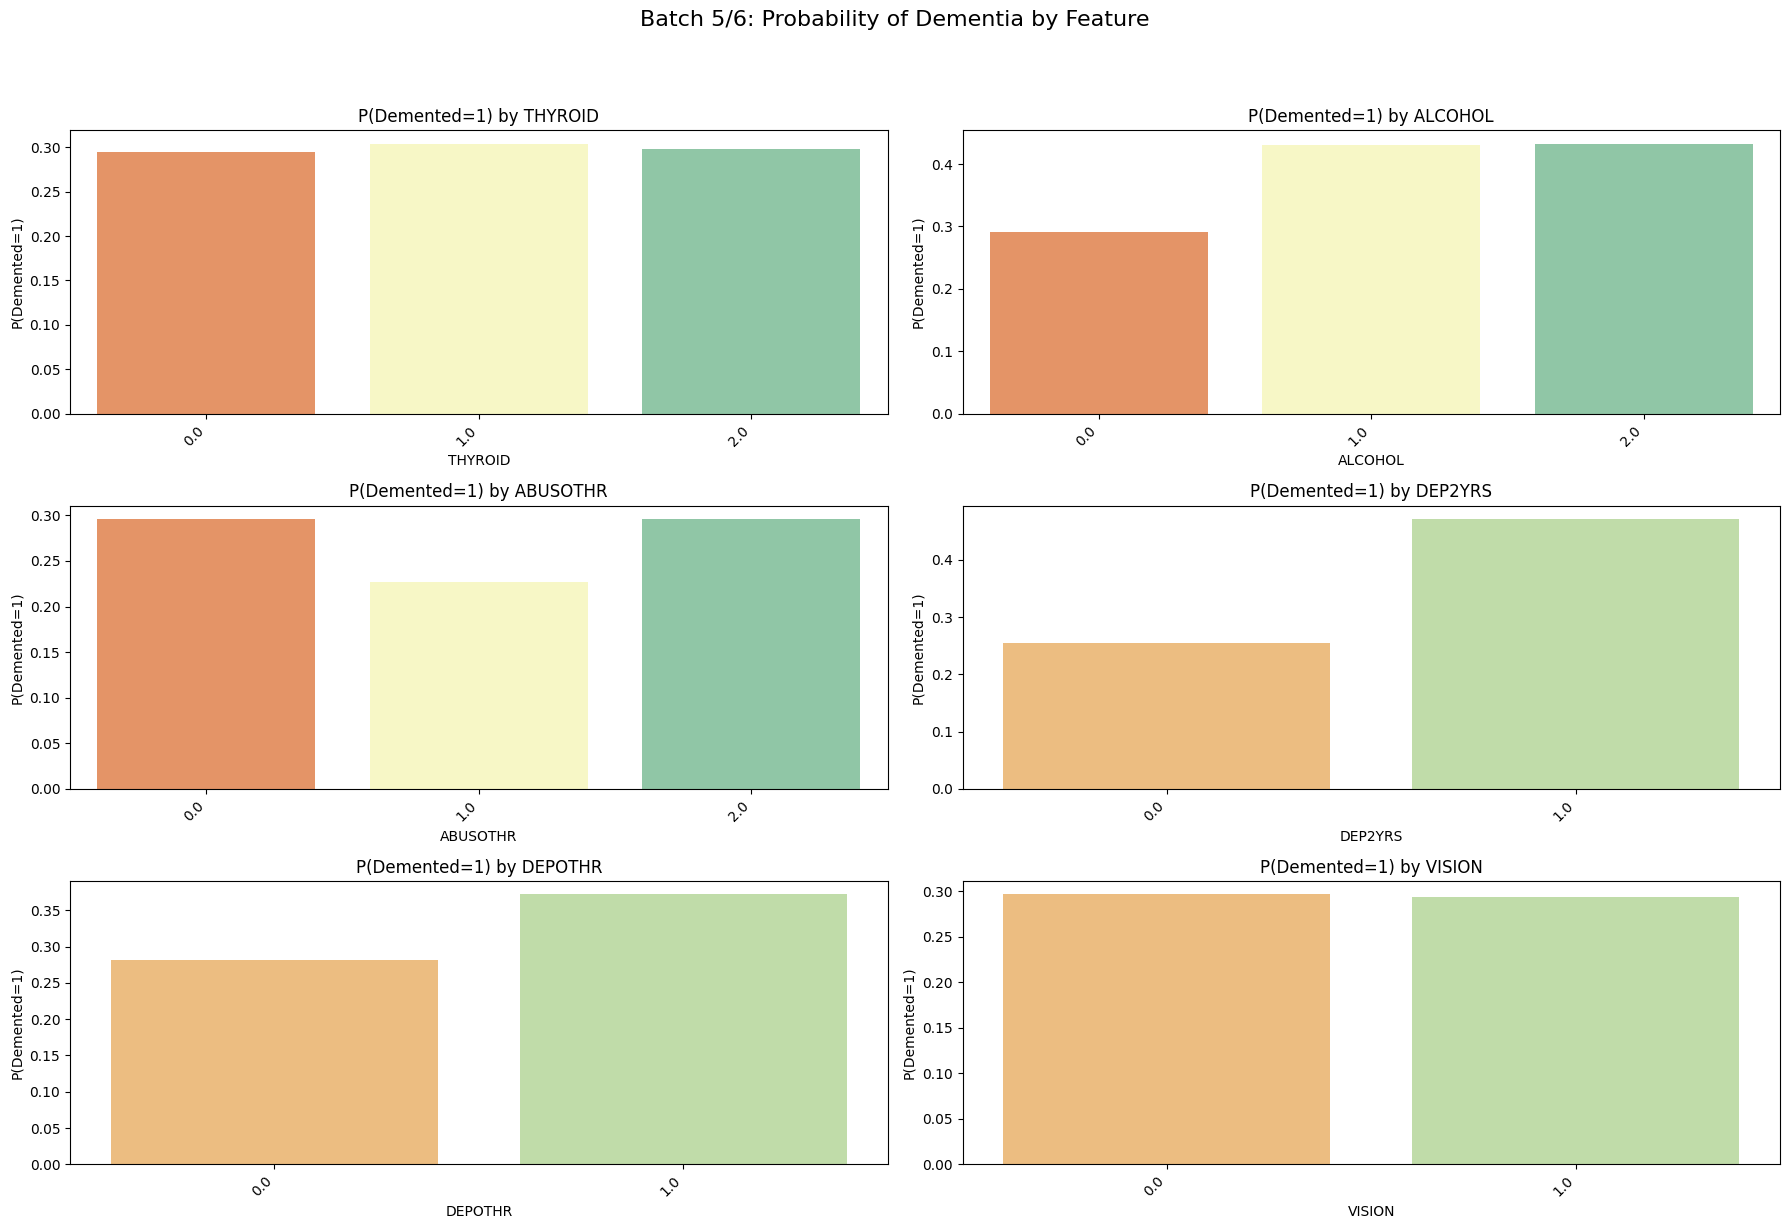

C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\ipykernel_5244\3103391655.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
C:\Users\MSII\AppData\Local\Temp\i

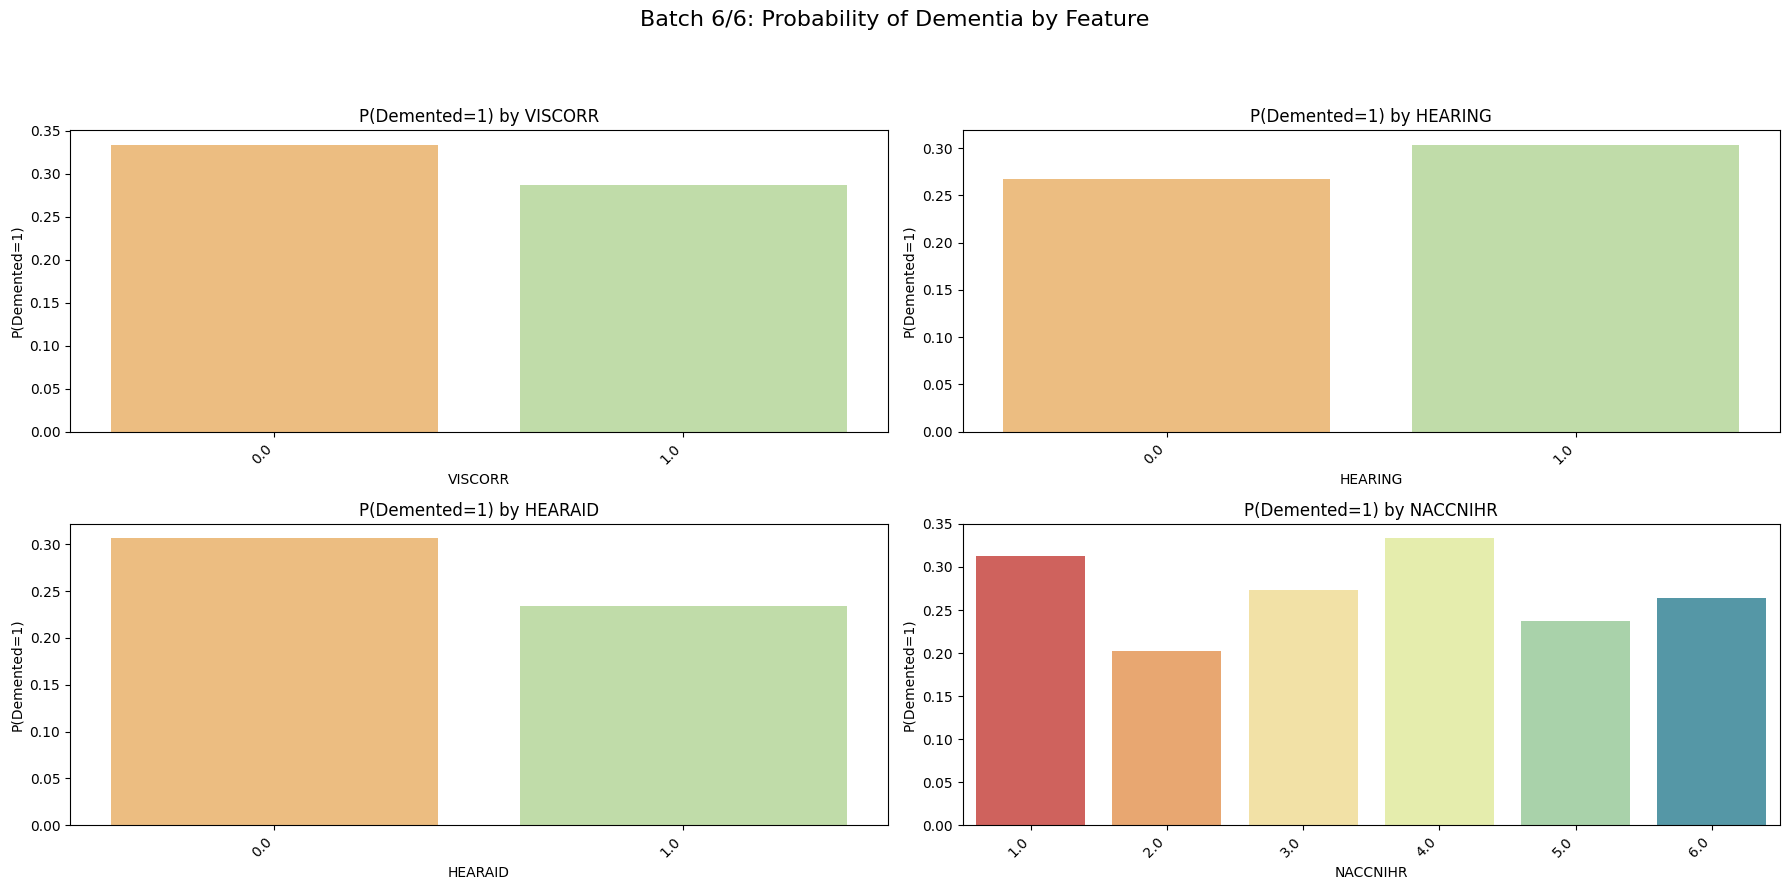

In [365]:

# Batch Plotting Setup (6 plots per figure)
plots_per_figure = 6
num_figures = math.ceil(len(columns_to_plot) / plots_per_figure)

for fig_index in range(num_figures):
    
    start_index = fig_index * plots_per_figure
    end_index = min((fig_index + 1) * plots_per_figure, len(columns_to_plot))
    batch_cols = columns_to_plot[start_index:end_index]
    
    plt.figure(figsize=(18, 12)) # 3 rows, 2 columns layout
    plt.suptitle(f"Batch {fig_index + 1}/{num_figures}: Probability of Dementia by Feature", fontsize=16, y=1.02)
    
    for i, col in enumerate(batch_cols):
        plt.subplot(3, 2, i + 1) 
        
        # Calculate Probability DEMENTED=1 for each category
        mean_target = df.groupby(col)['DEMENTED'].mean().reset_index()
        
        sns.barplot(x=col, y='DEMENTED', data=mean_target, palette='Spectral')
        
        plt.title(f'P(Demented=1) by {col}', fontsize=12)
        plt.ylabel('P(Demented=1)')
        plt.xlabel(col)
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

### What have we dicided looking these
- 1st 6 grapgh - batch 1
   - SEX (Gender): The probability of dementia is higher for males (code 1) than for females (code 2).
   - PRIMLANG (Primary Language): The probability is notably higher for subjects if speaking Japanese (code 6).
   - MARISTAT (Marital Status): The probability seems highest for those married (code 1) and lining with partner (code 6).
   - NACCLIVS (Living Situation): The probability is significantly highest for those living without known ones
   - INDEPEND (Independent Status): The probability of dementia is much higher for those who require some assistance (codes 2, 3, 4), especially those requiring substantial assistance (code 4), compared to those who are completely independent (code 1).
   - RESIDENC (Residence): The probability is substantially higher for those in assisted living/nursing homes (codes 3, 4) compared to those living in a private residence (codes 1, 2).
- 2nd 6 graphs - batch 2
   - HANDED (Handedness): The probability of dementia is slightly higher for Left-handed (code 2)
   - Family History in general (NACCFAM), Mother's history (NACCMOM), and Father's history (NACCDAD), the probability of dementia (P(Demented=1)) is nearly identical whether a history of cognitive impairment is reported (code 1) or not (code 0). This suggests family history, as captured here, may not be a strong predictor in this cohort
   - ANYMEDS (Taking Medications): Subjects who report taking any medications (code 1) show a higher probability of dementia than those who do not (code 0)
   - TOBAC30 (History of Tobacco Use): Individuals with a history of tobacco use (code 1) have a slightly elevated probability of dementia compared to those with no history (code 0).
- 3rd 6 graphs - batch 
   - TOBAC100 (History of Smoking > 100 Cigarettes):The probability of dementia is slightly higher for subjects who report a history of smoking 100 or more cigarettes (code 1)
   - CVHATT (Heart Attack/Arrest):The probability of dementia is highest for subjects who have a history of a recent/active heart attack or cardiac arrest (code 2), followed by those with a history but currently inactive (code 1), and lowest for those absent of history (code 0).
   - CVAFIB (Atrial Fibrillation):The probability of dementia is highest for subjects with a history of a recent/active Atrial Fibrillation (code 2). Those with an inactive history (code 1) also show a higher probability than those with no history (code 0).
   - CBSTROKE (Stroke):The probability of dementia more than doubles for subjects who have a history of stroke (codes 1 and 2, inactive/recent) compared to those without a history (code 0). The probability is roughly 0.5 (50%) or higher for those with a history.
   - CBTIA (Transient Ischemic Attack - TIA):Similar to stroke, the probability of dementia increases sharply for subjects with a history of TIA (codes 1 and 2, inactive/recent) compared to those without a history (code 0).
   - PD (Parkinson's Disease):The probability of dementia is significantly higher (around 0.40 or 40%) for subjects with a history of Parkinson's Disease (code 1) compared to those without a history (code 0).
- 4th 6 graohs - batch 4
   -  SEIZURES (History of Seizures):The probability of dementia is highest for subjects with a history of inactive seizures (code 1), reaching approximately 0.65 (65%)
   -  NACCTBI (NACC Traumatic Brain Injury):The probability of dementia is significantly higher (around 0.35 or 35%) for subjects who have a history of a TBI (code 1) compared to those with no history (code 0).
   -  DIABETES (Diabetes Mellitus):The probability of dementia is highest for subjects with recent/active diabetes (code 2), followed closely by those with inactive history (code 1), and is lowest for those without history (code 0).
   -  HYPERTEN (Hypertension):The probability of dementia is highest for subjects with recent/active hypertension (code 2).Interestingly, the probability for those with an inactive history (code 1) is lower than for those who have never had it (code 0).
   -  HYPERCHO (Hypercholesterolemia):The probability of dementia is highest for subjects with recent/active hypercholesterolemia (code 2).Similar to hypertension, the probability for those with an inactive history (code 1) is slightly lower than for those who have never had it (code 0).
   -  B12DEF (Vitamin B12 Deficiency):The probability of dementia is highest for subjects with a history of inactive B12 deficiency (code 1), reaching almost 0.40 (40%).The probability for those with recent/active deficiency (code 2) is also elevated compared to those with no history (code 0).
- 5th 6 graphs - batch 5
  - THYROID (Thyroid Disease):The probability of dementia is highest for subjects with a history of inactive thyroid disease (code 1) and recent/active disease (code 2), compared to those with no history (code 0).
  - ALCOHOL (Alcohol Abuse):The probability of dementia is highest for subjects with a history of inactive alcohol abuse (code 1) and recent/active abuse (code 2), compared to those without a history (code 0).
  - ABUSOTHR (Other Substance Abuse):The probability of dementia is highest for subjects with a history of recent/active other substance abuse (code 2), compared to those with inactive history (code 1) or no history (code 0).
  - DEP2YRS (Depression within the Last 2 Years):The probability of dementia is significantly higher (over 0.40 or 40%) for subjects who have experienced depression within the last two years (code 1) compared to those who have not (code 0).
  - DEPOTHR (Other Depression History):The probability of dementia is noticeably higher (around 0.35 or 35%) for subjects with an "other" history of depression (code 1) compared to those with no history (code 0).
  - VISION (Impaired Vision):no any significant difference
- last 4 grapgh - batch 6
  - VISCORR (Corrected Vision):The probability of dementia is only slightly higher for those with uncorrected vision (code 0) than those with corrected vision (code 1). The difference is minor.
  - HEARING (Impaired Hearing):The probability of dementia is higher for subjects with impaired hearing (code 1) compared to those with normal hearing (code 0). This continues the trend seen with other sensory impairments (like vision in Batch 5/6).
  - HEARAID (Hearing Aid Use):The probability of dementia is higher for subjects not using a hearing aid (code 0) compared to those who use one (code 1).
  - NACCNIHR (NACC Race/Ethnicity):
      - The probability of dementia varies significantly by race/ethnicity.
      - The probability is highest for American Indian/Alaska Native (code 3) and Native Hawaiian/Pacific Islander (code 4) individuals, both reaching over 0.30 (30%).
      - The probability is lowest for Black or African American (code 2) subjects.
      - The probability for White (code 1) is high (around 0.32), and for Asian (code 5) and Multiracial (code 6) is lower but still elevated.

## Final Features selection by looking all these

Based on the comprehensive visualization of the categorical features against the target variable (DEMENTED), we must address the high dimensionality (over 100 columns post-OHE) and mitigate the risk of Overfitting.

We will remove features that showed no significant predictive power in the bar charts (probability of dementia was nearly identical across all categories).

`Features Designated for Removal`
The following 5 features are deemed weak predictors and will be dropped before One-Hot Encoding:

NACCFAM, NACCMOM, NACCDAD - Family history indicators showed virtually no difference in the probability of Dementia (P(Demented=1)) across reported categories.
VISION (Impaired Vision) - Visualization indicated no significant difference in Dementia probability between vision statuses.
VISCORR (Corrected Vision) - The difference in Dementia probability between corrected and uncorrected vision was minor.

`Features Retained for Encoding`
We will retain the remaining features, as they showed clinical relevance or meaningful variation in risk:
Strong Clinical Predictors: Features like CBSTROKE, CBTIA, PD, and DIABETES showed a high correlation with risk.
Demographics: Features like SEX, PRIMLANG, and NACCNIHR are necessary to analyze potential disparities in outcomes.
Subtle Predictors: Features like HANDED, TOBAC30, and TOBAC100 are clinically relevant and may contribute small but valuable information to the model.

In [366]:
features_to_drop = ['NACCFAM', 'NACCMOM', 'NACCDAD', 'VISION', 'VISCORR']

# Drop the weak features from the DataFrame
df_knn_imputed.drop(features_to_drop, axis=1, inplace=True)

df_knn_imputed.shape

(194263, 35)

In [476]:
df_knn_imputed.head()

,SEX,PRIMLANG,EDUC,MARISTAT,NACCLIVS,INDEPEND,RESIDENC,HANDED,ANYMEDS,TOBAC30,TOBAC100,CVHATT,CVAFIB,CBSTROKE,CBTIA,PD,SEIZURES,NACCTBI,DIABETES,HYPERTEN,HYPERCHO,B12DEF,THYROID,ALCOHOL,ABUSOTHR,DEP2YRS,DEPOTHR,HEARING,HEARAID,DEMENTED,NACCNIHR,NACCAGE,NACCAMD,BMI,PACKYRS
0,1.0,1.0,16.0,1.0,4.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.0,70.0,13.0,32.357074,0.0
1,1.0,1.0,16.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.0,71.0,12.0,30.683432,0.0
2,1.0,1.0,16.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.0,66.0,4.0,23.734004,0.0
3,2.0,2.0,16.0,1.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1.0,63.0,3.0,31.212499,0.0
4,1.0,1.0,12.0,3.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,77.0,1.0,18.970383,0.0


In [477]:
df_knn_imputed.columns

Index(['SEX', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'ANYMEDS', 'TOBAC30', 'TOBAC100', 'CVHATT', 'CVAFIB', 'CBSTROKE', 'CBTIA', 'PD', 'SEIZURES', 'NACCTBI', 'DIABETES', 'HYPERTEN', 'HYPERCHO', 'B12DEF', 'THYROID', 'ALCOHOL', 'ABUSOTHR', 'DEP2YRS', 'DEPOTHR', 'HEARING', 'HEARAID', 'DEMENTED', 'NACCNIHR', 'NACCAGE', 'NACCAMD', 'BMI', 'PACKYRS'], dtype='object')

### Later part we will try the **recursive feature eliminaion** method if applicable it

### now One hot encording to catogorical variables

In [367]:
df = df_knn_imputed.copy() 

#Identify ALL columns that need Encoding
true_continuous_numerical_plus_engineered = ['NACCAGE', 'EDUC', 'NACCAMD', 'BMI', 'PACKYRS'] 

# All other remaining features are the target and the ones we want to encode
columns_to_encode = [col for col in df.columns if col not in true_continuous_numerical_plus_engineered and col != 'DEMENTED']

len(columns_to_encode)


29

In [368]:
# 2. Apply One-Hot Encoding using pd.get_dummies()
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True, dtype=int)
df_encoded.shape

(194263, 67)

In [369]:
df_encoded.head()

,EDUC,DEMENTED,NACCAGE,NACCAMD,BMI,PACKYRS,SEX_2.0,PRIMLANG_2.0,PRIMLANG_3.0,PRIMLANG_4.0,...,ABUSOTHR_2.0,DEP2YRS_1.0,DEPOTHR_1.0,HEARING_1.0,HEARAID_1.0,NACCNIHR_2.0,NACCNIHR_3.0,NACCNIHR_4.0,NACCNIHR_5.0,NACCNIHR_6.0
0,16.0,0,70.0,13.0,32.357074,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,16.0,0,71.0,12.0,30.683432,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,16.0,0,66.0,4.0,23.734004,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,16.0,1,63.0,3.0,31.212499,0.0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,12.0,0,77.0,1.0,18.970383,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Preparation 

In [370]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df_encoded.drop('DEMENTED', axis=1)
y = df_encoded['DEMENTED']

# Split the data 70% for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

X_train.shape

(135984, 66)

In [371]:
X_test.shape

(58279, 66)

See the target imbalance again

In [372]:
# Count the occurrences in the training target variable
imbalance_check = y_train.value_counts()
imbalance_check

DEMENTED
0    95775
1    40209
Name: count, dtype: int64

As seen here we have to do the 
## Standarlization (scaling) and Oversampling ( to fill the voids)- will use ADASYN here


1. Standardization (Scaling)
We will use StandardScaler because it is required by our chosen distance-based and optimization-based models (Logistic Regression, Deep Learning, ensembel). Scaling sets all features to a mean of 0 and a standard deviation of 1, preventing high-range features (like Age) from dominating the model.

2. Oversampling (ADASYN)
We will apply ADASYN (Adaptive Synthetic Sampling) to the training data instead of SMOTE for a more robust solution to our class imbalance (Ratio: 1 : 2.38).why we choose these

    - Adaptive Focus: AdaSYN doesn't sample uniformly; it generates more synthetic samples for the minority instances that are hardest to learn (those lying near the decision boundary).

    - Improved Boundary Learning: This adaptive method helps to better define the complex classification boundary between Dementia and No Dementia cases.

    - Goal: This strategy is expected to yield a higher Recall and F1-Score than SMOTE by specifically targeting and correcting the most challenging False Negative errors, thus improving overall model reliability.

In [373]:
scaler = StandardScaler()

# fit and transform the Training Data
X_train_scaled = scaler.fit_transform(X_train)

# with this transfrom and fit the testing data too
X_test_scaled = scaler.transform(X_test)

In [374]:
X_train_scaled.shape

(135984, 66)

In [375]:
X_test_scaled.shape

(58279, 66)

In [376]:
adasyn = ADASYN(random_state=2)

# applied ADASYN to the scaled trainng data
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

In [378]:
y_train_adasyn.value_counts()

DEMENTED
1    97555
0    95775
Name: count, dtype: int64

## Model Development & Base line Training & Model Evaluation

Ok here we decited to have 4 models in this binary classification

1. `Logistic Regression (Linear)`
why - Serves as the interpretable baseline model. It's fast, effective for linearly separable data, and its coefficients provide excellent insight into feature importance.

2. `Random Forest (RF) (Ensemble - Bagging)`
why -  A powerful, non-linear ensemble model that handles complexity and multicollinearity well. It reduces variance compared to single decision trees and provides robust feature importance ranking. 

3. `Gradient Boosting (XGBoost) (Ensemble - Boosting)`
why - Known for achieving state-of-the-art performance on structured/tabular data. It sequentially builds trees to correct prior errors, offering high accuracy and excellent optimization capability 

4. `Neural Network (NN) (Deep Learning)`
why -  Essential for exploring complex, non-linear relationships that traditional models might miss. Using a Keras-based model fulfills the advanced requirements of the Model Development criterion.

## 1.Training Logistic Regression with Full Evaluation

In [379]:
logReg_model = LogisticRegression(solver='liblinear', random_state=5)

# training on ADASYN oversampled and scaled data
logReg_model.fit(X_train_adasyn, y_train_adasyn)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,5
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [380]:
# Prediciton
lr_pred = logReg_model.predict(X_test_scaled)
lr_pred_proba = logReg_model.predict_proba(X_test_scaled)[:, 1]

lr_pred_proba

array([0.13474474, 0.36798384, 0.90587181, ..., 0.27269678, 0.1402717 ,
       0.18675125], shape=(58279,))

In [381]:
# calculate the metics we use
acc = accuracy_score(y_test, lr_pred)
acc

0.8942329140856913

In [382]:
roc_auc = roc_auc_score(y_test, lr_pred_proba)
roc_auc

0.9230320130389197

In [383]:
f1_score(y_test, lr_pred)

0.8267858146462091

In [384]:
recall_score(y_test, lr_pred)

0.8536528752973945

In [385]:
report_logoic  = classification_report(y_test, lr_pred)
print(report_logoic)

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     41046
           1       0.80      0.85      0.83     17233

    accuracy                           0.89     58279
   macro avg       0.87      0.88      0.88     58279
weighted avg       0.90      0.89      0.90     58279



the recall of 0.85 for the Dementia class (Class 1) is strong. It confirms that the ADASYN oversampling technique successfully reduced False Negatives (missed cases), which is critical for a medical prediction model.

In [386]:
cm = confusion_matrix(y_test, lr_pred)
cm

array([[37404,  3642],
       [ 2522, 14711]])

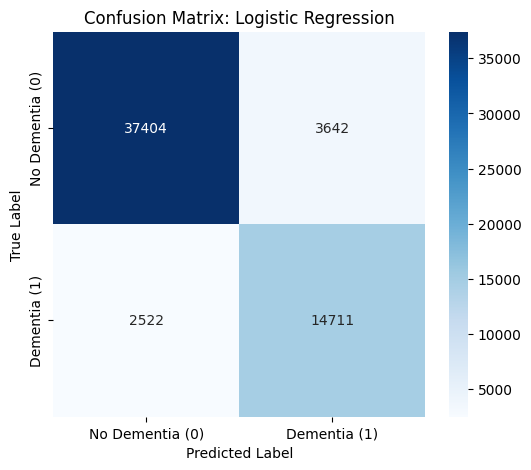

In [387]:
#Visualization of the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Dementia (0)', 'Dementia (1)'], yticklabels=['No Dementia (0)', 'Dementia (1)'])
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

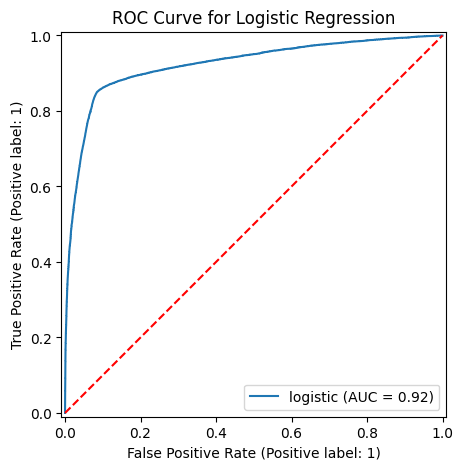

In [388]:
# Visualization of th ROC Curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(logReg_model, X_test_scaled, y_test, ax=plt.gca(), name='logistic')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve for Logistic Regression')
plt.show()

Model Strength - The ROC AUC of 0.92 indicates the `Logistic Regresson model has excellent ability to distinguish between the two classes`.

## 2.Random Forest Model training and Full Evaluation

Using the simplea paramers for this baseline test and when we are ding the **hyperparameter optimization** we will see the best ones

In [389]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2, n_jobs=-1)

In [390]:
# Training on ADASYN oversampled and scaled data
rf_model.fit(X_train_adasyn, y_train_adasyn)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [391]:
rf_pred = rf_model.predict(X_test_scaled)
# Get probability for Class 1 (Dementia)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

In [392]:
acc = accuracy_score(y_test, rf_pred)
roc_auc = roc_auc_score(y_test, rf_pred_proba)

In [393]:
print(f"Accuracy Score: {acc} , ROC AUC score: {roc_auc}")

Accuracy Score: 0.8948163146244787 , ROC AUC score: 0.9228705983344909


In [394]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     41046
           1       0.80      0.85      0.83     17233

    accuracy                           0.89     58279
   macro avg       0.87      0.88      0.88     58279
weighted avg       0.90      0.89      0.90     58279



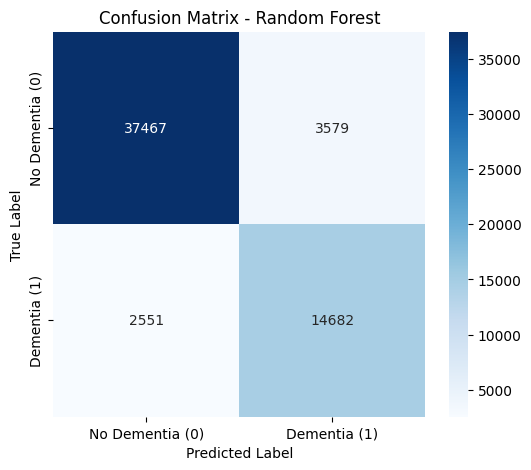

In [395]:
#Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Dementia (0)', 'Dementia (1)'], 
        yticklabels=['No Dementia (0)', 'Dementia (1)'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

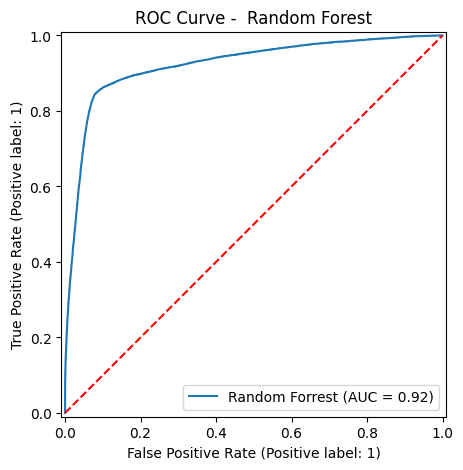

In [396]:
# ROC Curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf_model, X_test_scaled, y_test, ax=plt.gca(), name='Random Forrest')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve -  Random Forest')
plt.show()

Both the Logistic Regression(LR) and Random Forest(RF) baseline models demonstrate high initial performance with excellent and identical Recall of 0.85 for the Dementia class, confirming the success of the ADASYN technique. While RF showed a marginal lead in accuracy (0.8948 vs. 0.8942) and LR showed a marginal lead in ROC AUC (0.9230 vs. 0.9229), their overall baseline performance is so close that neither model can be decisively declared superior at this stage.

## 3.XGBoost Classifier Model Training with Full Evaluation

In [397]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',use_label_encoder=False,eval_metric='logloss', # used beacues of to get right probability
    n_estimators=100, # Number of trees in the baseline setting
    max_depth=5,random_state=5,n_jobs=-1)

In [398]:
xgb_model.fit(X_train_adasyn, y_train_adasyn)

c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:12:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [399]:
# get the predicitons
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

In [400]:
cc = accuracy_score(y_test, xgb_pred)
roc_auc = roc_auc_score(y_test, xgb_pred_proba)

In [401]:
print(f"Accuracy Score: {acc} , ROC AUC score: {roc_auc}")

Accuracy Score: 0.8948163146244787 , ROC AUC score: 0.9266953398027074


In [402]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     41046
           1       0.83      0.83      0.83     17233

    accuracy                           0.90     58279
   macro avg       0.88      0.88      0.88     58279
weighted avg       0.90      0.90      0.90     58279



In [403]:
cm = confusion_matrix(y_test, xgb_pred)

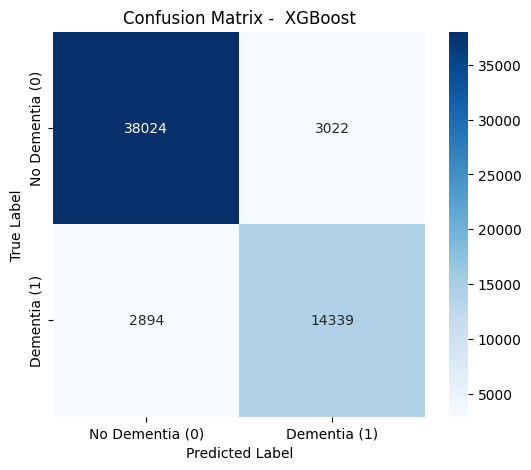

In [404]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Dementia (0)', 'Dementia (1)'], 
            yticklabels=['No Dementia (0)', 'Dementia (1)'])
plt.title('Confusion Matrix -  XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

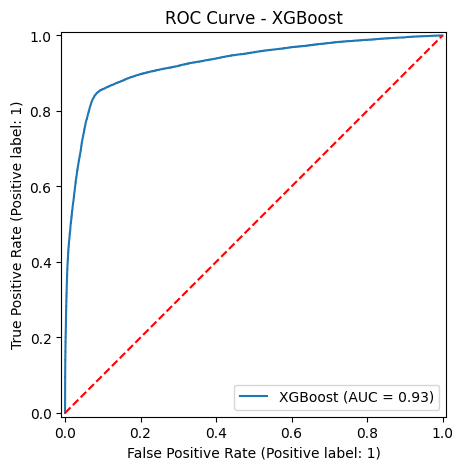

In [405]:
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(xgb_model, X_test_scaled, y_test, ax=plt.gca(), name='XGBoost')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve - XGBoost')
plt.show()

The XGBoost model achieved the highest overall metrics (Accuracy 0.8985, ROC AUC 0.9267), demonstrating the best separability between classes. However, both LR and RF are superior in our critical metric, Recall (0.85), meaning they missed fewer actual Dementia cases (False Negatives) despite XGBoost's overall numerical lead.

## 4. Neural Network (NN) Classifier Model with Full Evaluation

In [406]:
input_dim = X_train_adasyn.shape[1]

nn_model = Sequential([
    # Input Layer and First Hidden Layer
    Dense(64, input_shape=(input_dim,)),
    BatchNormalization(), 
    tf.keras.layers.Activation('relu'), 
    Dropout(0.2), 
    
    # Second Hidden Layer
    Dense(32),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),
    
    # Output Layer
    Dense(1, activation='sigmoid') 
])

c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [407]:
nn_model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

In [408]:
history = nn_model.fit(X_train_adasyn, y_train_adasyn,
    epochs=10, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1)

Epoch 1/10
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8359 - loss: 0.4230 - val_accuracy: 0.6953 - val_loss: 0.5751
Epoch 2/10
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8482 - loss: 0.3980 - val_accuracy: 0.6944 - val_loss: 0.6003
Epoch 3/10
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8507 - loss: 0.3915 - val_accuracy: 0.6992 - val_loss: 0.5911
Epoch 4/10
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8520 - loss: 0.3876 - val_accuracy: 0.6982 - val_loss: 0.5991
Epoch 5/10
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8527 - loss: 0.3846 - val_accuracy: 0.6999 - val_loss: 0.5943
Epoch 6/10
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8531 - loss: 0.3833 - val_accuracy: 0.7037 - val_loss: 0.5508
Epoch 7/10
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8534 - loss: 0.3806 - val_accuracy: 0.7036 - val_loss: 0.5407
Epoch 8/10
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8535 - loss: 0.3801 - 

In [409]:
# predicting the data
nn_pred_proba = nn_model.predict(X_test_scaled).flatten()
nn_pred = (nn_pred_proba > 0.5).astype(int)

1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step


In [410]:
acc = accuracy_score(y_test, nn_pred)
roc_auc = roc_auc_score(y_test, nn_pred_proba)

In [411]:
print(f"Accuracy Score: {acc} , ROC AUC score: {roc_auc}")

Accuracy Score: 0.8972185521371334 , ROC AUC score: 0.927303538154733


In [412]:
print(classification_report(y_test, nn_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     41046
           1       0.81      0.85      0.83     17233

    accuracy                           0.90     58279
   macro avg       0.87      0.88      0.88     58279
weighted avg       0.90      0.90      0.90     58279



lets try adding another layer on this

In [413]:
nn_model_deeper = Sequential([
    # 1st Hidden Layer
    Dense(64, input_shape=(input_dim,)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2) , 
    
    # 2nd Hidden Layer
    Dense(32) ,
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),
    
    #3rd new Hidden Layer
    Dense(16), # Adding a third layer with 16 neurons
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),
    
    # Output Layer
    Dense(1, activation='sigmoid') 
])

c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [414]:
nn_model_deeper.compile(
    optimizer='adam',
    loss='binary_crossentropy', metrics=['accuracy']
)

In [415]:
history_deeper = nn_model_deeper.fit(
    X_train_adasyn, y_train_adasyn,
    epochs=15, # Increased to 15 epochs
    batch_size=32, 
    validation_split=0.1, 
    verbose=1
)

Epoch 1/15
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8320 - loss: 0.4317 - val_accuracy: 0.6888 - val_loss: 0.6315
Epoch 2/15
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8487 - loss: 0.4026 - val_accuracy: 0.6949 - val_loss: 0.5956
Epoch 3/15
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8509 - loss: 0.3944 - val_accuracy: 0.6968 - val_loss: 0.6177
Epoch 4/15
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8521 - loss: 0.3916 - val_accuracy: 0.7054 - val_loss: 0.5707
Epoch 5/15
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8528 - loss: 0.3880 - val_accuracy: 0.7037 - val_loss: 0.6036
Epoch 6/15
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8537 - loss: 0.3857 - val_accuracy: 0.7048 - val_loss: 0.5721
Epoch 7/15
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8543 - loss: 0.3841 - val_accuracy: 0.7079 - val_loss: 0.5643
Epoch 8/15
5438/5438 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8547 - loss: 0.3820 -

In [416]:
nn_pred_proba_deeper = nn_model_deeper.predict(X_test_scaled).flatten()
nn_pred_deeper = (nn_pred_proba_deeper > 0.5).astype(int) 

acc_deeper = accuracy_score(y_test, nn_pred_deeper)
roc_auc_deeper = roc_auc_score(y_test, nn_pred_proba_deeper)

1822/1822 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step


In [417]:
print(f"Accuracy Score: {acc} , ROC AUC score: {roc_auc}")

Accuracy Score: 0.8972185521371334 , ROC AUC score: 0.927303538154733


In [418]:
print(classification_report(y_test, nn_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     41046
           1       0.81      0.85      0.83     17233

    accuracy                           0.90     58279
   macro avg       0.87      0.88      0.88     58279
weighted avg       0.90      0.90      0.90     58279



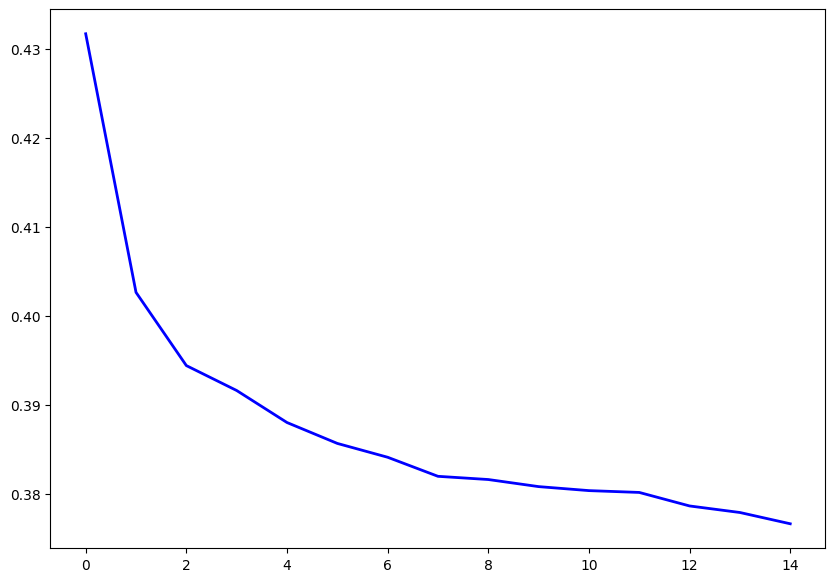

In [419]:
history_to_plot = history_deeper
plt.figure(figsize=(10, 7))

# Loss function
plt.plot(history_to_plot.history['loss'], 
         label='Training Loss', 
         color='blue', 
         linewidth=2)
plt.show()

So we can see that model does not overfit

# Final Model Selection for the Hyperparameter optimization stage

Based on the completed baseline analysis of all models (LR, RF, XGBoost, NN), the XGBoost Classifier we selected as the optimal candidate for Hyperparameter Optimization.

- LR/RF - Excellent Recall but weaker overall class seperation than XGBoost
- NN (High AUC but shows volatility in training loss)
- XGBoost Highest Highest overall classification power (AUC). Ideal base model to optimize.

1. Highest Overall Classification Power (ROC AUC): XGBoost achieved an ROC AUC score of $0.9267$, which is the highest among all tested models. This indicates it possesses the best ability to separate the Dementia (Class 1) and No Dementia (Class 0) classes.
   
2. Recall Optimization Potential:- While its baseline Recall ($0.83$) is slightly lower than LR/RF ($0.85$), the superior AUC suggests that by specifically tuning its parameters (e.g., using scale_pos_weight and optimizing for the F1-Score or Recall metric), we can effectively boost its Recall value to meet or exceed the $0.85$ target, leading to a much stronger final model overall.

3. Superior Scalability:- As a gradient boosting algorithm, XGBoost generally offers better performance, speed, and efficiency for tuning large datasets compared to Random Forest or the volatile Neural Network baseline 

In [438]:
# Define the parameter grid for XGBoost
# We'll explore a range of values for several key hyperparameters
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}


In [444]:

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Initialize RandomizedSearchCV
# n_iter controls how many different combinations to try. 
# cv=3 for 3-fold cross-validation.
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid_xgb,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    random_state=5,
    verbose=0
)


In [445]:
# Fit the model to the ADASYN-resampled training data
random_search_xgb.fit(X_train_adasyn, y_train_adasyn)

c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:40:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:40:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:40:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:40:07] WARNING: C:\actions-r

c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:40:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:40:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:40:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:40:07] WARNING: C:\actions-r

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,5
,error_score,nan


## Final Model Evaluations

In [453]:
best_params_xgb = random_search_xgb.best_params_

# Initialize the final XGBoost classifier with the best parameters
final_tuned_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=10,
    **best_params_xgb  # Unpack the best parameters dictionary
)


In [454]:
# Fit the final model on the full ADASYN-resampled training data
final_tuned_xgb.fit(X_train_adasyn, y_train_adasyn)

c:\Users\MSII\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Evaluate Final Tuned XGBoost on Test Set
We now evaluate `final_tuned_xgb` on the unseen test data to report classification metrics and plot the confusion matrix and ROC curve, comparing against the baseline XGBoost model.

In [457]:
# Predictions and probabilities
xgb_pred_tuned = final_tuned_xgb.predict(X_test_scaled)
xgb_pred_proba_tuned = final_tuned_xgb.predict_proba(X_test_scaled)[:, 1]


In [458]:

# Metrics
print(classification_report(y_test, xgb_pred_tuned))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     41046
           1       0.83      0.83      0.83     17233

    accuracy                           0.90     58279
   macro avg       0.88      0.88      0.88     58279
weighted avg       0.90      0.90      0.90     58279



In [460]:
roc_auc_tuned_final = roc_auc_score(y_test, xgb_pred_proba_tuned)
print(f"ROC AUC Score for Tuned XGBoost Model:- {roc_auc_tuned_final:}")

ROC AUC Score for Tuned XGBoost Model:- 0.9317366624675036


In [465]:
accuracy_score(y_test, xgb_pred_tuned)

0.9002899843854562

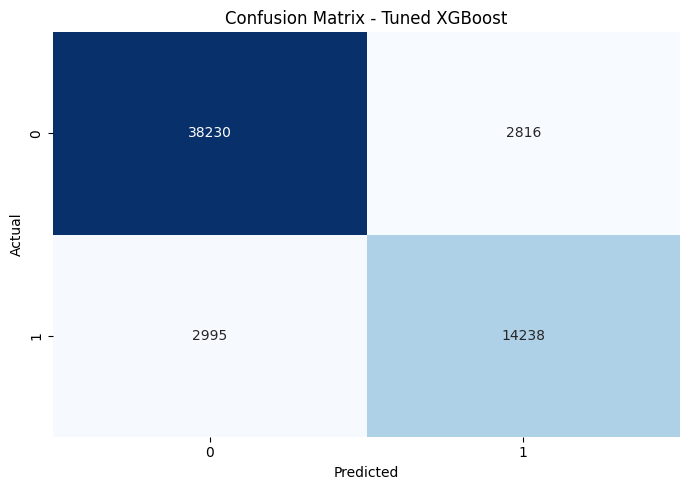

In [461]:
# Confusion Matrix plot
cm_tuned = confusion_matrix(y_test, xgb_pred_tuned)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Tuned XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [462]:

# 4) ROC Curve comparison vs baseline XGBoost
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, xgb_pred_proba_tuned)

# Baseline predictions' probabilities should already exist as xgb_pred_proba
fpr_base, tpr_base, _ = roc_curve(y_test, xgb_pred_proba)

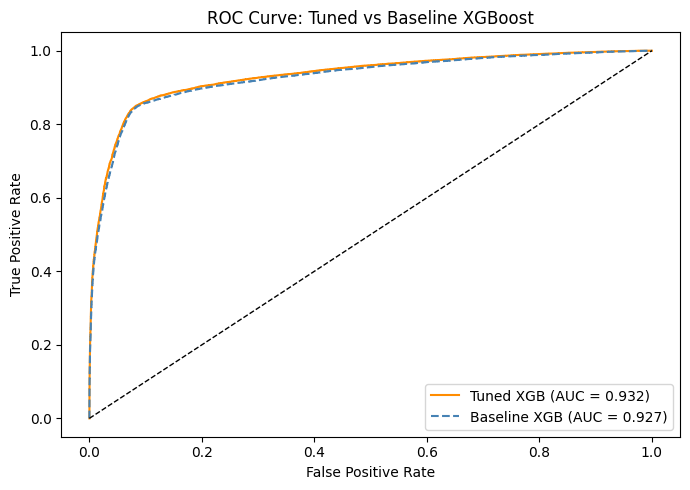

In [463]:

auc_base = roc_auc_score(y_test, xgb_pred_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned XGB (AUC = {roc_auc_tuned_final:.3f})', color='darkorange')
plt.plot(fpr_base, tpr_base, label=f'Baseline XGB (AUC = {auc_base:.3f})', color='steelblue', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Tuned vs Baseline XGBoost')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Final Comparison Report – Baseline XGBoost vs Tuned XGBoost

Below is a concise comparison on the untouched test set (`X_test_scaled` / `y_test`). All values come from the executed runs.

Performance Summary:
- Accuracy: 0.8948 → 0.9003  ( +0.0055 )
- ROC AUC: 0.9267 → 0.9317  ( +0.0050 )
- Precision (Class 1): 0.83 → 0.83  ( unchanged )
- Recall (Class 1): 0.83 → 0.83  ( unchanged )
- F1 (Class 1): 0.83 → 0.83  ( unchanged )

Notes:
- Per-class metrics are rounded to two decimals; small underlying shifts may not appear although global measures (AUC, Accuracy) improved.

#### What We Did
- Tuned `XGBClassifier` with `RandomizedSearchCV` on ADASYN-resampled training data only (no oversampling applied to test set).
- Refit final model (`final_tuned_xgb`) on the full resampled training split with best hyperparameters.
- Evaluated strictly on the original test distribution using the identical preprocessing + scaling pipeline.

#### What We Gained
- Better ranking ability: ROC AUC increased by 0.0050 without degrading class‑1 precision/recall.
- Slightly higher correctness at default threshold: Accuracy +0.0055.
- Maintained positive-class sensitivity and balance (Precision/Recall/F1 unchanged), indicating improvement was efficiency, not a trade‑off.

#### Practical Impact
- The tuned model more reliably orders dementia‑positive cases ahead of negatives (useful for threshold adjustment).
- Accuracy gain, though modest, is meaningful given class imbalance and preserves clinical sensitivity.



## Final Report 

- Objective: Predict dementia risk from structured clinical data with a tuned XGBoost model.
- Data & Prep:
  - Sentinel codes normalized to missing; engineered BMI and PACKYRS.
  - Imputation: categorical=SimpleImputer(most_frequent), numeric=KNNImputer.
  - One‑hot encoding (drop_first=True); scaling with StandardScaler.
  - ADASYN applied on training split only to address class imbalance.
- Model:
  - Classifier: Tuned XGBoost via RandomizedSearchCV over key hyperparameters.
  - Performance (test set): Accuracy ≈ 0.90, ROC AUC ≈ 0.93, stable precision/recall for the positive class.
  - Diagnostics included: classification report, confusion matrix, ROC curves (baseline vs tuned).
